# Some preliminary tests. I have already done some testing with NN previously. Here we look for any signs of good Loss reduction and prediction accuracy and shift them to the following tests for further optimisation.

Result: We find with the Standard model it tend to predict Normal labels better but with SMOTE we can force the model to prioritise threats without a significant impact on false predictions on Normal labels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_23236\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# STANDARD TUNING

Epoch 1/5: 100%|██████████| 15876/15876 [01:29<00:00, 177.81batch/s]


Epoch [1/5], Train Loss: 0.0204, Train Acc: 0.9908, Train F1: 0.9907


Epoch 2/5: 100%|██████████| 15876/15876 [01:24<00:00, 188.45batch/s]


Epoch [2/5], Train Loss: 0.0194, Train Acc: 0.9914, Train F1: 0.9913


Epoch 3/5: 100%|██████████| 15876/15876 [01:27<00:00, 180.73batch/s]


Epoch [3/5], Train Loss: 0.0195, Train Acc: 0.9914, Train F1: 0.9914


Epoch 4/5: 100%|██████████| 15876/15876 [01:30<00:00, 175.36batch/s]


Epoch [4/5], Train Loss: 0.0193, Train Acc: 0.9915, Train F1: 0.9915


Epoch 5/5: 100%|██████████| 15876/15876 [01:33<00:00, 169.98batch/s]


Epoch [5/5], Train Loss: 0.0193, Train Acc: 0.9914, Train F1: 0.9913


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 322.33batch/s]


Test Loss: 0.0212, Test Accuracy: 0.9919, Test F1: 0.9917


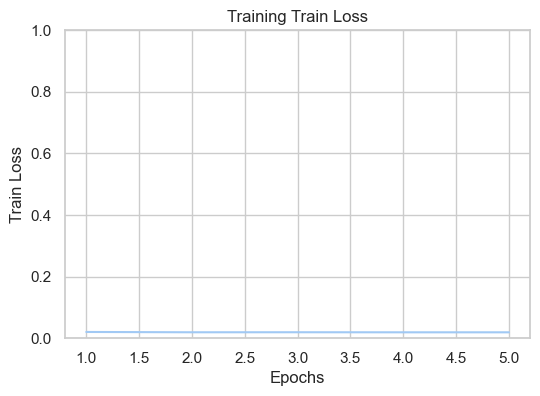

Standard Test


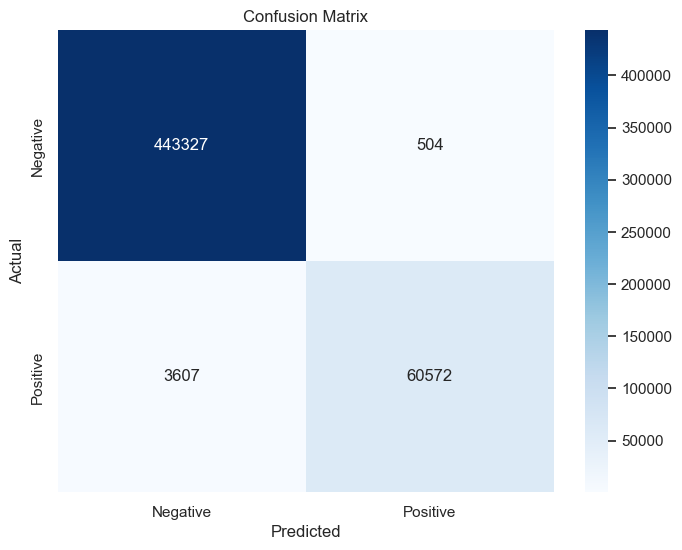

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/01'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [01:31<00:00, 174.30batch/s]


Epoch [1/20], Train Loss: 0.0148, Train Acc: 0.9926, Train F1: 0.9925


Epoch 2/20: 100%|██████████| 15876/15876 [01:32<00:00, 171.33batch/s]


Epoch [2/20], Train Loss: 0.0133, Train Acc: 0.9933, Train F1: 0.9932


Epoch 3/20: 100%|██████████| 15876/15876 [01:33<00:00, 170.66batch/s]


Epoch [3/20], Train Loss: 0.0130, Train Acc: 0.9935, Train F1: 0.9934


Epoch 4/20: 100%|██████████| 15876/15876 [01:35<00:00, 166.66batch/s]


Epoch [4/20], Train Loss: 0.0129, Train Acc: 0.9935, Train F1: 0.9934


Epoch 5/20: 100%|██████████| 15876/15876 [01:30<00:00, 175.89batch/s]


Epoch [5/20], Train Loss: 0.0128, Train Acc: 0.9935, Train F1: 0.9934


Epoch 6/20: 100%|██████████| 15876/15876 [01:31<00:00, 172.80batch/s]


Epoch [6/20], Train Loss: 0.0128, Train Acc: 0.9935, Train F1: 0.9934


Epoch 7/20: 100%|██████████| 15876/15876 [01:44<00:00, 152.56batch/s]


Epoch [7/20], Train Loss: 0.0127, Train Acc: 0.9936, Train F1: 0.9934


Epoch 8/20: 100%|██████████| 15876/15876 [01:41<00:00, 156.48batch/s]


Epoch [8/20], Train Loss: 0.0127, Train Acc: 0.9936, Train F1: 0.9935


Epoch 9/20: 100%|██████████| 15876/15876 [01:34<00:00, 168.11batch/s]


Epoch [9/20], Train Loss: 0.0126, Train Acc: 0.9936, Train F1: 0.9935


Epoch 10/20: 100%|██████████| 15876/15876 [01:41<00:00, 155.99batch/s]


Epoch [10/20], Train Loss: 0.0126, Train Acc: 0.9936, Train F1: 0.9935


Epoch 11/20: 100%|██████████| 15876/15876 [01:36<00:00, 164.32batch/s]


Epoch [11/20], Train Loss: 0.0125, Train Acc: 0.9937, Train F1: 0.9935


Epoch 12/20: 100%|██████████| 15876/15876 [01:43<00:00, 153.67batch/s]


Epoch [12/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 13/20: 100%|██████████| 15876/15876 [01:36<00:00, 164.03batch/s]


Epoch [13/20], Train Loss: 0.0125, Train Acc: 0.9937, Train F1: 0.9935


Epoch 14/20: 100%|██████████| 15876/15876 [01:42<00:00, 155.53batch/s]


Epoch [14/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Epoch 15/20: 100%|██████████| 15876/15876 [01:43<00:00, 153.79batch/s]


Epoch [15/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 16/20: 100%|██████████| 15876/15876 [02:05<00:00, 126.44batch/s]


Epoch [16/20], Train Loss: 0.0124, Train Acc: 0.9936, Train F1: 0.9935


Epoch 17/20: 100%|██████████| 15876/15876 [01:54<00:00, 138.16batch/s]


Epoch [17/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Epoch 18/20: 100%|██████████| 15876/15876 [01:43<00:00, 153.28batch/s]


Epoch [18/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Epoch 19/20: 100%|██████████| 15876/15876 [01:45<00:00, 150.50batch/s]


Epoch [19/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Epoch 20/20: 100%|██████████| 15876/15876 [02:54<00:00, 91.10batch/s] 


Epoch [20/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Testing: 100%|██████████| 3969/3969 [00:15<00:00, 255.00batch/s]


Test Loss: 0.0124, Test Accuracy: 0.9940, Test F1: 0.9939


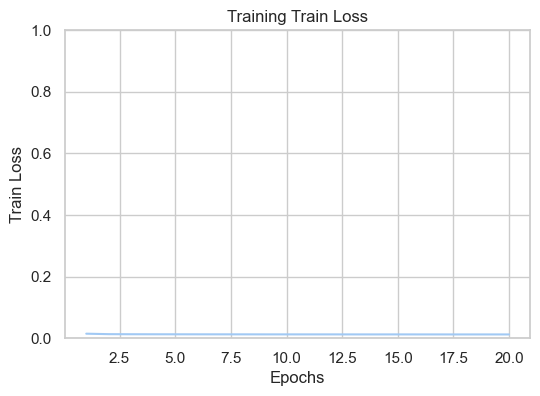

Standard Test


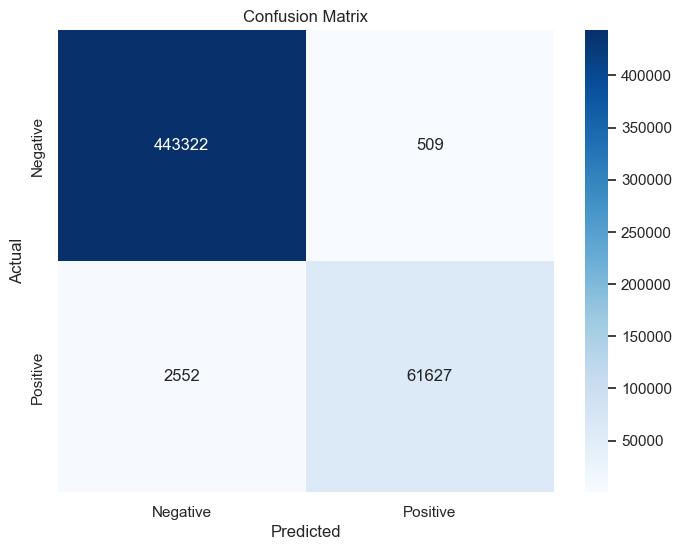

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/001'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.01
epochs = 20
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/10: 100%|██████████| 15876/15876 [02:07<00:00, 124.89batch/s]


Epoch [1/10], Train Loss: 0.0173, Train Acc: 0.9908, Train F1: 0.9906


Epoch 2/10: 100%|██████████| 15876/15876 [02:05<00:00, 126.12batch/s]


Epoch [2/10], Train Loss: 0.0167, Train Acc: 0.9910, Train F1: 0.9907


Epoch 3/10: 100%|██████████| 15876/15876 [02:22<00:00, 111.55batch/s]


Epoch [3/10], Train Loss: 0.0165, Train Acc: 0.9910, Train F1: 0.9907


Epoch 4/10: 100%|██████████| 15876/15876 [01:44<00:00, 151.51batch/s]


Epoch [4/10], Train Loss: 0.0165, Train Acc: 0.9910, Train F1: 0.9907


Epoch 5/10: 100%|██████████| 15876/15876 [01:31<00:00, 173.81batch/s]


Epoch [5/10], Train Loss: 0.0168, Train Acc: 0.9908, Train F1: 0.9905


Epoch 6/10: 100%|██████████| 15876/15876 [01:32<00:00, 172.36batch/s]


Epoch [6/10], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Epoch 7/10: 100%|██████████| 15876/15876 [01:33<00:00, 169.19batch/s]


Epoch [7/10], Train Loss: 0.0167, Train Acc: 0.9910, Train F1: 0.9908


Epoch 8/10: 100%|██████████| 15876/15876 [01:33<00:00, 170.28batch/s]


Epoch [8/10], Train Loss: 0.0167, Train Acc: 0.9909, Train F1: 0.9906


Epoch 9/10: 100%|██████████| 15876/15876 [01:31<00:00, 172.90batch/s]


Epoch [9/10], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Epoch 10/10: 100%|██████████| 15876/15876 [01:35<00:00, 165.52batch/s]


Epoch [10/10], Train Loss: 0.0164, Train Acc: 0.9911, Train F1: 0.9909


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 324.90batch/s]

Test Loss: 0.0177, Test Accuracy: 0.9922, Test F1: 0.9920


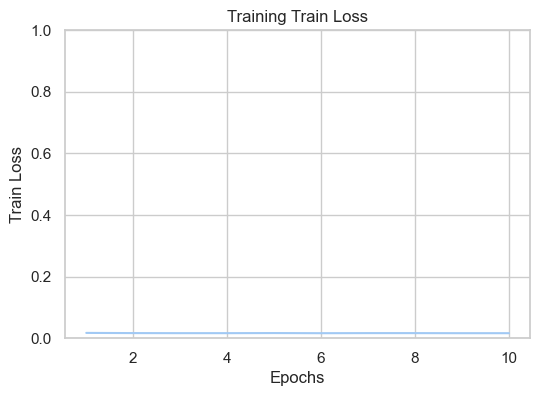

Standard Test


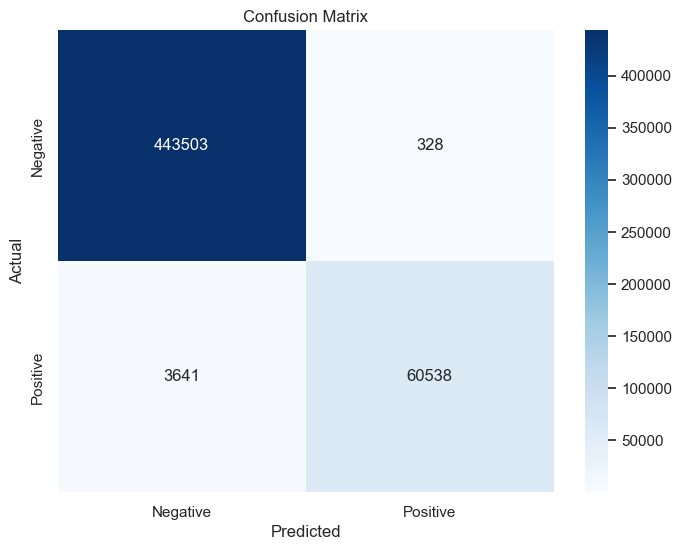

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/09'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.09
epochs = 10
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/15: 100%|██████████| 15876/15876 [01:34<00:00, 168.87batch/s]


Epoch [1/15], Train Loss: 0.0174, Train Acc: 0.9911, Train F1: 0.9909


Epoch 2/15: 100%|██████████| 15876/15876 [01:30<00:00, 175.26batch/s]


Epoch [2/15], Train Loss: 0.0167, Train Acc: 0.9912, Train F1: 0.9909


Epoch 3/15: 100%|██████████| 15876/15876 [01:28<00:00, 179.43batch/s]


Epoch [3/15], Train Loss: 0.0165, Train Acc: 0.9912, Train F1: 0.9910


Epoch 4/15: 100%|██████████| 15876/15876 [01:27<00:00, 181.62batch/s]


Epoch [4/15], Train Loss: 0.0167, Train Acc: 0.9905, Train F1: 0.9902


Epoch 5/15: 100%|██████████| 15876/15876 [01:29<00:00, 177.61batch/s]


Epoch [5/15], Train Loss: 0.0167, Train Acc: 0.9906, Train F1: 0.9904


Epoch 6/15: 100%|██████████| 15876/15876 [01:31<00:00, 172.71batch/s]


Epoch [6/15], Train Loss: 0.0161, Train Acc: 0.9914, Train F1: 0.9912


Epoch 7/15: 100%|██████████| 15876/15876 [01:31<00:00, 173.73batch/s]


Epoch [7/15], Train Loss: 0.0160, Train Acc: 0.9915, Train F1: 0.9913


Epoch 8/15: 100%|██████████| 15876/15876 [01:29<00:00, 177.56batch/s]


Epoch [8/15], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 9/15: 100%|██████████| 15876/15876 [01:30<00:00, 176.29batch/s]


Epoch [9/15], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9910


Epoch 10/15: 100%|██████████| 15876/15876 [01:30<00:00, 174.97batch/s]


Epoch [10/15], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9908


Epoch 11/15: 100%|██████████| 15876/15876 [01:31<00:00, 174.14batch/s]


Epoch [11/15], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9911


Epoch 12/15: 100%|██████████| 15876/15876 [01:39<00:00, 160.18batch/s]


Epoch [12/15], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Epoch 13/15: 100%|██████████| 15876/15876 [01:29<00:00, 176.51batch/s]


Epoch [13/15], Train Loss: 0.0162, Train Acc: 0.9911, Train F1: 0.9909


Epoch 14/15: 100%|██████████| 15876/15876 [01:28<00:00, 178.66batch/s]


Epoch [14/15], Train Loss: 0.0164, Train Acc: 0.9912, Train F1: 0.9910


Epoch 15/15: 100%|██████████| 15876/15876 [01:31<00:00, 173.60batch/s]


Epoch [15/15], Train Loss: 0.0164, Train Acc: 0.9911, Train F1: 0.9908


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 316.14batch/s]

Test Loss: 0.0150, Test Accuracy: 0.9922, Test F1: 0.9920


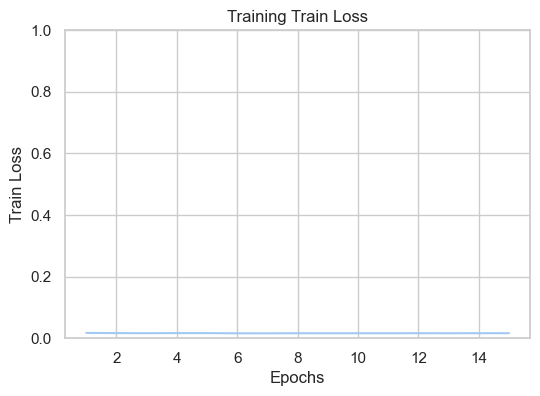

Standard Test


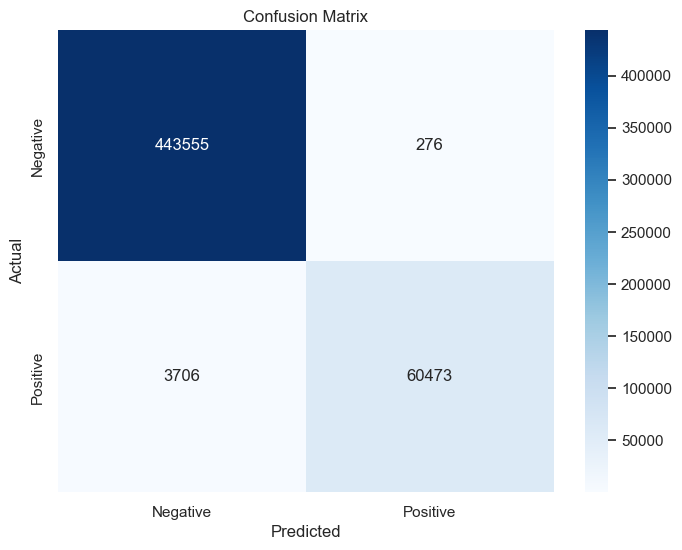

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/08'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 15
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [01:33<00:00, 169.43batch/s]


Epoch [1/20], Train Loss: 0.0168, Train Acc: 0.9914, Train F1: 0.9912


Epoch 2/20: 100%|██████████| 15876/15876 [01:34<00:00, 167.59batch/s]


Epoch [2/20], Train Loss: 0.0162, Train Acc: 0.9915, Train F1: 0.9914


Epoch 3/20: 100%|██████████| 15876/15876 [01:38<00:00, 161.54batch/s]


Epoch [3/20], Train Loss: 0.0162, Train Acc: 0.9915, Train F1: 0.9913


Epoch 4/20: 100%|██████████| 15876/15876 [01:40<00:00, 158.16batch/s]


Epoch [4/20], Train Loss: 0.0159, Train Acc: 0.9916, Train F1: 0.9914


Epoch 5/20: 100%|██████████| 15876/15876 [01:55<00:00, 137.25batch/s]


Epoch [5/20], Train Loss: 0.0160, Train Acc: 0.9916, Train F1: 0.9914


Epoch 6/20: 100%|██████████| 15876/15876 [02:00<00:00, 131.22batch/s]


Epoch [6/20], Train Loss: 0.0160, Train Acc: 0.9914, Train F1: 0.9912


Epoch 7/20: 100%|██████████| 15876/15876 [02:05<00:00, 126.47batch/s]


Epoch [7/20], Train Loss: 0.0159, Train Acc: 0.9915, Train F1: 0.9913


Epoch 8/20: 100%|██████████| 15876/15876 [02:08<00:00, 123.22batch/s]


Epoch [8/20], Train Loss: 0.0157, Train Acc: 0.9917, Train F1: 0.9915


Epoch 9/20: 100%|██████████| 15876/15876 [02:09<00:00, 122.26batch/s]


Epoch [9/20], Train Loss: 0.0159, Train Acc: 0.9916, Train F1: 0.9914


Epoch 10/20: 100%|██████████| 15876/15876 [02:08<00:00, 123.99batch/s]


Epoch [10/20], Train Loss: 0.0158, Train Acc: 0.9916, Train F1: 0.9914


Epoch 11/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.91batch/s]


Epoch [11/20], Train Loss: 0.0159, Train Acc: 0.9916, Train F1: 0.9914


Epoch 12/20: 100%|██████████| 15876/15876 [01:57<00:00, 134.61batch/s]


Epoch [12/20], Train Loss: 0.0159, Train Acc: 0.9915, Train F1: 0.9913


Epoch 13/20: 100%|██████████| 15876/15876 [01:33<00:00, 170.62batch/s]


Epoch [13/20], Train Loss: 0.0159, Train Acc: 0.9916, Train F1: 0.9913


Epoch 14/20: 100%|██████████| 15876/15876 [01:44<00:00, 151.70batch/s]


Epoch [14/20], Train Loss: 0.0160, Train Acc: 0.9913, Train F1: 0.9911


Epoch 15/20: 100%|██████████| 15876/15876 [01:29<00:00, 177.15batch/s]


Epoch [15/20], Train Loss: 0.0159, Train Acc: 0.9915, Train F1: 0.9912


Epoch 16/20: 100%|██████████| 15876/15876 [01:33<00:00, 170.61batch/s]


Epoch [16/20], Train Loss: 0.0160, Train Acc: 0.9914, Train F1: 0.9912


Epoch 17/20: 100%|██████████| 15876/15876 [01:33<00:00, 170.10batch/s]


Epoch [17/20], Train Loss: 0.0159, Train Acc: 0.9914, Train F1: 0.9912


Epoch 18/20: 100%|██████████| 15876/15876 [02:01<00:00, 130.69batch/s]


Epoch [18/20], Train Loss: 0.0160, Train Acc: 0.9914, Train F1: 0.9912


Epoch 19/20: 100%|██████████| 15876/15876 [02:04<00:00, 127.66batch/s]


Epoch [19/20], Train Loss: 0.0158, Train Acc: 0.9916, Train F1: 0.9914


Epoch 20/20: 100%|██████████| 15876/15876 [02:00<00:00, 131.49batch/s]


Epoch [20/20], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9911


Testing: 100%|██████████| 3969/3969 [00:15<00:00, 261.78batch/s]


Test Loss: 0.0158, Test Accuracy: 0.9912, Test F1: 0.9909


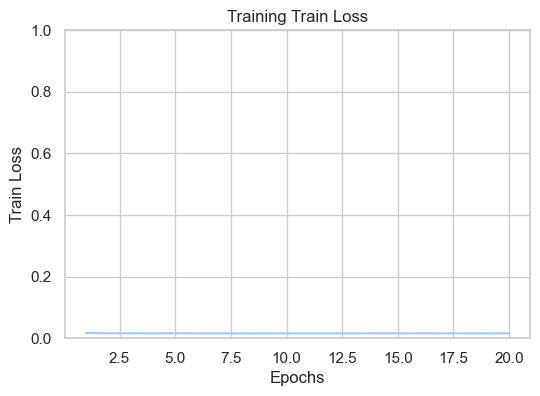

Standard Test


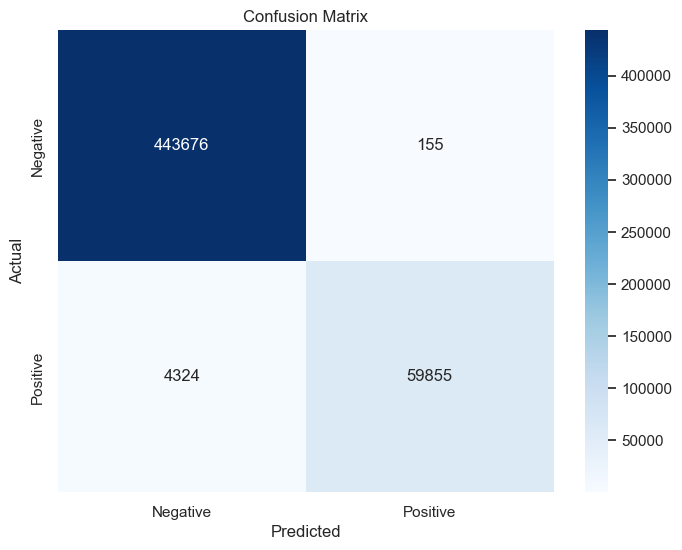

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/07'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.07
epochs = 20
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

# Layer

Epoch 1/20: 100%|██████████| 15876/15876 [02:03<00:00, 128.59batch/s]


Epoch [1/20], Train Loss: 0.0172, Train Acc: 0.9913, Train F1: 0.9911


Epoch 2/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.31batch/s]


Epoch [2/20], Train Loss: 0.0165, Train Acc: 0.9913, Train F1: 0.9911


Epoch 3/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.24batch/s]


Epoch [3/20], Train Loss: 0.0175, Train Acc: 0.9898, Train F1: 0.9895


Epoch 4/20: 100%|██████████| 15876/15876 [01:51<00:00, 142.18batch/s]


Epoch [4/20], Train Loss: 0.0166, Train Acc: 0.9909, Train F1: 0.9907


Epoch 5/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.87batch/s]


Epoch [5/20], Train Loss: 0.0167, Train Acc: 0.9908, Train F1: 0.9905


Epoch 6/20: 100%|██████████| 15876/15876 [02:44<00:00, 96.23batch/s] 


Epoch [6/20], Train Loss: 0.0174, Train Acc: 0.9899, Train F1: 0.9896


Epoch 7/20: 100%|██████████| 15876/15876 [02:42<00:00, 97.57batch/s] 


Epoch [7/20], Train Loss: 0.0169, Train Acc: 0.9905, Train F1: 0.9903


Epoch 8/20: 100%|██████████| 15876/15876 [02:44<00:00, 96.59batch/s] 


Epoch [8/20], Train Loss: 0.0183, Train Acc: 0.9889, Train F1: 0.9886


Epoch 9/20: 100%|██████████| 15876/15876 [02:44<00:00, 96.71batch/s] 


Epoch [9/20], Train Loss: 0.0172, Train Acc: 0.9902, Train F1: 0.9900


Epoch 10/20: 100%|██████████| 15876/15876 [02:45<00:00, 95.86batch/s] 


Epoch [10/20], Train Loss: 0.0177, Train Acc: 0.9896, Train F1: 0.9893


Epoch 11/20: 100%|██████████| 15876/15876 [01:52<00:00, 141.04batch/s]


Epoch [11/20], Train Loss: 0.0174, Train Acc: 0.9899, Train F1: 0.9897


Epoch 12/20: 100%|██████████| 15876/15876 [01:46<00:00, 149.69batch/s]


Epoch [12/20], Train Loss: 0.0173, Train Acc: 0.9899, Train F1: 0.9896


Epoch 13/20: 100%|██████████| 15876/15876 [01:45<00:00, 149.83batch/s]


Epoch [13/20], Train Loss: 0.0174, Train Acc: 0.9900, Train F1: 0.9897


Epoch 14/20: 100%|██████████| 15876/15876 [01:45<00:00, 150.26batch/s]


Epoch [14/20], Train Loss: 0.0173, Train Acc: 0.9903, Train F1: 0.9900


Epoch 15/20: 100%|██████████| 15876/15876 [01:46<00:00, 149.42batch/s]


Epoch [15/20], Train Loss: 0.0180, Train Acc: 0.9895, Train F1: 0.9892


Epoch 16/20: 100%|██████████| 15876/15876 [01:51<00:00, 142.43batch/s]


Epoch [16/20], Train Loss: 0.0174, Train Acc: 0.9903, Train F1: 0.9900


Epoch 17/20: 100%|██████████| 15876/15876 [01:50<00:00, 143.86batch/s]


Epoch [17/20], Train Loss: 0.0180, Train Acc: 0.9894, Train F1: 0.9891


Epoch 18/20: 100%|██████████| 15876/15876 [01:51<00:00, 142.01batch/s]


Epoch [18/20], Train Loss: 0.0180, Train Acc: 0.9893, Train F1: 0.9890


Epoch 19/20: 100%|██████████| 15876/15876 [02:49<00:00, 93.54batch/s] 


Epoch [19/20], Train Loss: 0.0183, Train Acc: 0.9887, Train F1: 0.9883


Epoch 20/20: 100%|██████████| 15876/15876 [02:46<00:00, 95.39batch/s] 


Epoch [20/20], Train Loss: 0.0171, Train Acc: 0.9902, Train F1: 0.9900


Testing: 100%|██████████| 3969/3969 [00:16<00:00, 235.41batch/s]

Test Loss: 0.0163, Test Accuracy: 0.9920, Test F1: 0.9919


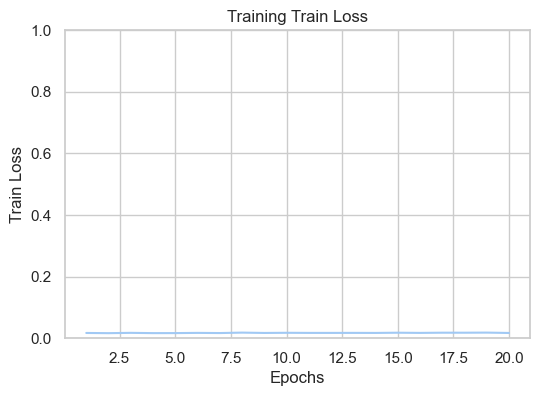

Standard Test


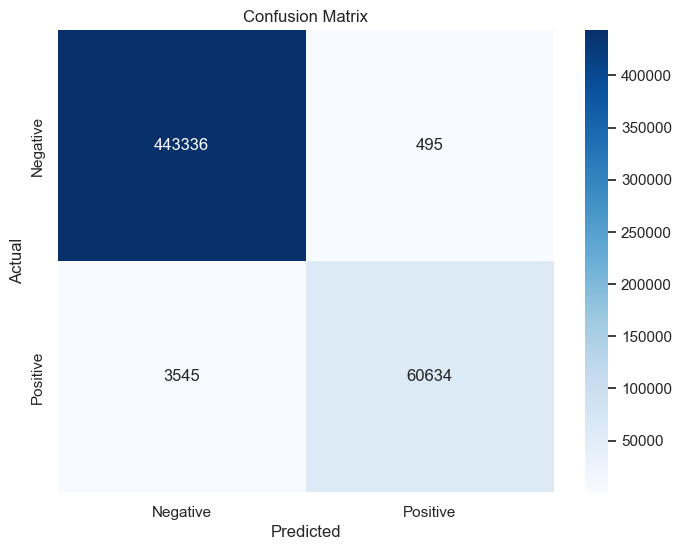

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/02/standard/07L256'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 20
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [02:54<00:00, 90.81batch/s] 


Epoch [1/20], Train Loss: 0.0175, Train Acc: 0.9911, Train F1: 0.9909


Epoch 2/20: 100%|██████████| 15876/15876 [03:03<00:00, 86.31batch/s] 


Epoch [2/20], Train Loss: 0.0166, Train Acc: 0.9915, Train F1: 0.9913


Epoch 3/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.97batch/s]


Epoch [3/20], Train Loss: 0.0167, Train Acc: 0.9911, Train F1: 0.9909


Epoch 4/20: 100%|██████████| 15876/15876 [02:05<00:00, 126.64batch/s]


Epoch [4/20], Train Loss: 0.0166, Train Acc: 0.9913, Train F1: 0.9910


Epoch 5/20: 100%|██████████| 15876/15876 [02:09<00:00, 122.88batch/s]


Epoch [5/20], Train Loss: 0.0166, Train Acc: 0.9909, Train F1: 0.9907


Epoch 6/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.56batch/s]


Epoch [6/20], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9907


Epoch 7/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.01batch/s]


Epoch [7/20], Train Loss: 0.0162, Train Acc: 0.9914, Train F1: 0.9912


Epoch 8/20: 100%|██████████| 15876/15876 [03:00<00:00, 88.03batch/s] 


Epoch [8/20], Train Loss: 0.0160, Train Acc: 0.9915, Train F1: 0.9913


Epoch 9/20: 100%|██████████| 15876/15876 [02:18<00:00, 114.56batch/s]


Epoch [9/20], Train Loss: 0.0163, Train Acc: 0.9913, Train F1: 0.9911


Epoch 10/20: 100%|██████████| 15876/15876 [03:06<00:00, 84.90batch/s]


Epoch [10/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9911


Epoch 11/20: 100%|██████████| 15876/15876 [03:13<00:00, 82.11batch/s] 


Epoch [11/20], Train Loss: 0.0161, Train Acc: 0.9912, Train F1: 0.9910


Epoch 12/20: 100%|██████████| 15876/15876 [03:28<00:00, 75.97batch/s]


Epoch [12/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9908


Epoch 13/20: 100%|██████████| 15876/15876 [03:29<00:00, 75.69batch/s]


Epoch [13/20], Train Loss: 0.0162, Train Acc: 0.9911, Train F1: 0.9908


Epoch 14/20: 100%|██████████| 15876/15876 [03:29<00:00, 75.77batch/s]


Epoch [14/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 15/20: 100%|██████████| 15876/15876 [03:27<00:00, 76.51batch/s]


Epoch [15/20], Train Loss: 0.0161, Train Acc: 0.9912, Train F1: 0.9910


Epoch 16/20: 100%|██████████| 15876/15876 [03:02<00:00, 86.76batch/s] 


Epoch [16/20], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9907


Epoch 17/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.59batch/s]


Epoch [17/20], Train Loss: 0.0162, Train Acc: 0.9911, Train F1: 0.9909


Epoch 18/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.74batch/s]


Epoch [18/20], Train Loss: 0.0163, Train Acc: 0.9910, Train F1: 0.9908


Epoch 19/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.83batch/s]


Epoch [19/20], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9910


Epoch 20/20: 100%|██████████| 15876/15876 [02:08<00:00, 123.89batch/s]


Epoch [20/20], Train Loss: 0.0163, Train Acc: 0.9910, Train F1: 0.9908


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 293.04batch/s]


Test Loss: 0.0167, Test Accuracy: 0.9913, Test F1: 0.9911


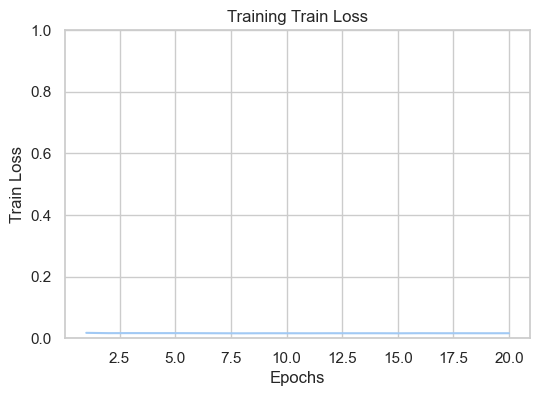

Standard Test


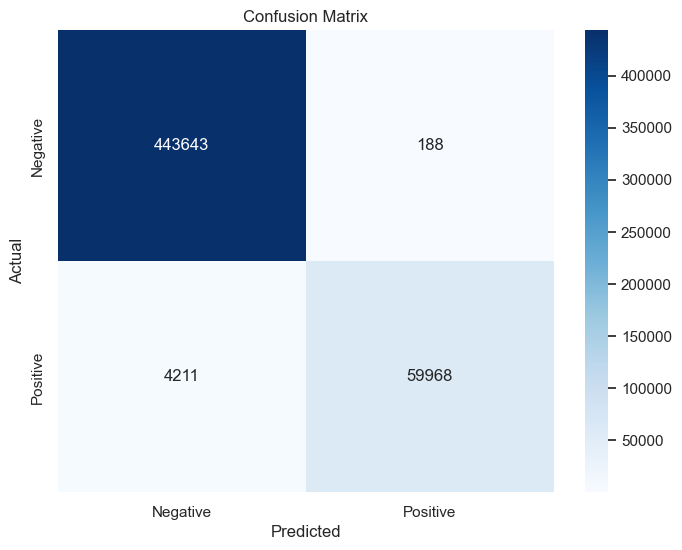

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/standard/09L512'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 20
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/5: 100%|██████████| 15876/15876 [01:51<00:00, 142.31batch/s]


Epoch [1/5], Train Loss: 0.0180, Train Acc: 0.9910, Train F1: 0.9907


Epoch 2/5: 100%|██████████| 15876/15876 [01:50<00:00, 143.83batch/s]


Epoch [2/5], Train Loss: 0.0170, Train Acc: 0.9909, Train F1: 0.9906


Epoch 3/5: 100%|██████████| 15876/15876 [01:54<00:00, 138.37batch/s]


Epoch [3/5], Train Loss: 0.0173, Train Acc: 0.9903, Train F1: 0.9901


Epoch 4/5: 100%|██████████| 15876/15876 [01:57<00:00, 134.82batch/s]


Epoch [4/5], Train Loss: 0.0170, Train Acc: 0.9906, Train F1: 0.9903


Epoch 5/5: 100%|██████████| 15876/15876 [02:17<00:00, 115.78batch/s]


Epoch [5/5], Train Loss: 0.0169, Train Acc: 0.9907, Train F1: 0.9905


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 292.40batch/s]

Test Loss: 0.0209, Test Accuracy: 0.9886, Test F1: 0.9882


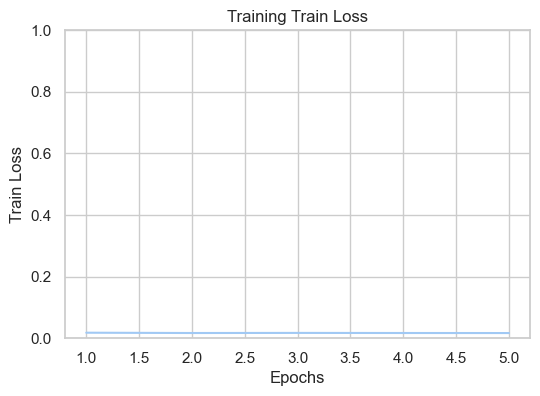

Standard Test


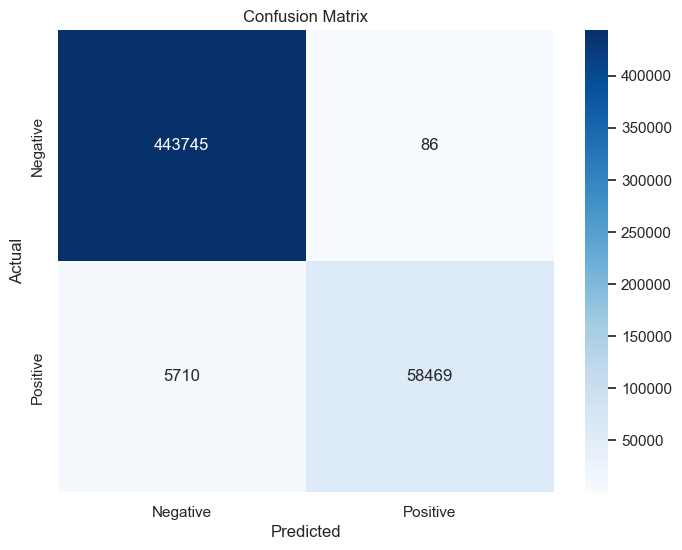

In [ ]:
# This is actually a potential candidate for further tests, the loss continues to decrease without reverting. This is looks like the almost inverse of SMOTE.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/standard/1L512'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Result: Nothing we do in terms of tuning seems to have a significant effect on minority labels.

# SMOTE TUNING

Layers on best current model.

Epoch 1/5:   6%|▌         | 921/15876 [00:14<03:47, 65.77batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  23%|██▎       | 3728/15876 [00:58<03:11, 63.51batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  28%|██▊       | 4371/15876 [01:08<02:55, 65.38batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  30%|██▉       | 4714/15876 [01:13<02:52, 64.60batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  35%|███▍      | 5485/15876 [01:26<02:34, 67.30batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  40%|███▉      | 6282/15876 [01:38<02:23, 66.69batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  43%|████▎     | 6905/15876 [01:48<02:23, 62.72batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  55%|█████▍    | 8707/15876 [02:17<01:53, 62.98batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  83%|████████▎ | 13254/15876 [03:30<00:43, 59.63batch/s]

Error running sampler. Using normal sample.


Epoch 1/5: 100%|██████████| 15876/15876 [04:12<00:00, 62.89batch/s]


Error running sampler. Using normal sample.
Epoch [1/5], Train Loss: 0.0201, Train Acc: 0.9916, Train F1: 0.9915


Epoch 2/5:   7%|▋         | 1064/15876 [00:17<03:50, 64.38batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  15%|█▌        | 2459/15876 [00:39<03:25, 65.20batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  23%|██▎       | 3609/15876 [00:57<03:06, 65.65batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  24%|██▍       | 3781/15876 [01:00<03:16, 61.59batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  41%|████      | 6437/15876 [01:44<02:31, 62.46batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  41%|████      | 6451/15876 [01:44<02:27, 63.73batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  47%|████▋     | 7387/15876 [02:00<02:13, 63.62batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  50%|█████     | 7971/15876 [02:09<02:04, 63.36batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  60%|██████    | 9558/15876 [02:34<01:42, 61.68batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  65%|██████▌   | 10353/15876 [02:47<01:25, 64.64batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  68%|██████▊   | 10739/15876 [02:53<01:24, 60.58batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  81%|████████  | 12783/15876 [03:26<00:47, 65.48batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  84%|████████▎ | 13286/15876 [03:34<00:40, 64.31batch/s]

Error running sampler. Using normal sample.


Epoch 2/5: 100%|██████████| 15876/15876 [04:15<00:00, 62.10batch/s]


Error running sampler. Using normal sample.
Epoch [2/5], Train Loss: 0.0181, Train Acc: 0.9915, Train F1: 0.9915


Epoch 3/5:   9%|▉         | 1433/15876 [00:22<03:43, 64.55batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  13%|█▎        | 2066/15876 [00:32<03:33, 64.67batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  15%|█▌        | 2434/15876 [00:38<03:28, 64.35batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  39%|███▉      | 6175/15876 [01:37<02:31, 63.97batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  40%|███▉      | 6302/15876 [01:39<02:26, 65.37batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  42%|████▏     | 6639/15876 [01:45<02:29, 61.73batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  45%|████▍     | 7107/15876 [01:52<02:21, 61.76batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  48%|████▊     | 7683/15876 [02:02<02:12, 62.04batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  51%|█████     | 8061/15876 [02:08<02:01, 64.13batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  55%|█████▍    | 8667/15876 [02:18<01:53, 63.27batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  67%|██████▋   | 10591/15876 [02:48<01:21, 64.97batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  75%|███████▍  | 11864/15876 [03:09<01:01, 64.90batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  82%|████████▏ | 12996/15876 [03:27<00:43, 66.52batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  88%|████████▊ | 13901/15876 [03:42<00:30, 64.47batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  96%|█████████▌| 15274/15876 [04:04<00:09, 65.62batch/s]

Error running sampler. Using normal sample.


Epoch 3/5: 100%|██████████| 15876/15876 [04:13<00:00, 62.52batch/s]


Error running sampler. Using normal sample.
Epoch [3/5], Train Loss: 0.0174, Train Acc: 0.9918, Train F1: 0.9918


Epoch 4/5:   4%|▍         | 648/15876 [00:10<03:59, 63.49batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:   6%|▋         | 1000/15876 [00:16<03:48, 65.21batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:   9%|▉         | 1434/15876 [00:22<04:10, 57.63batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  33%|███▎      | 5297/15876 [01:24<02:44, 64.29batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  35%|███▌      | 5622/15876 [01:30<02:36, 65.52batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  47%|████▋     | 7450/15876 [01:59<02:12, 63.37batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  47%|████▋     | 7521/15876 [02:00<02:12, 63.23batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  76%|███████▋  | 12140/15876 [03:16<00:58, 63.42batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  80%|████████  | 12776/15876 [03:27<00:50, 61.61batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  81%|████████  | 12803/15876 [03:27<00:51, 59.37batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  84%|████████▍ | 13357/15876 [03:37<00:41, 60.13batch/s]

Error running sampler. Using normal sample.


Epoch 4/5: 100%|██████████| 15876/15876 [04:18<00:00, 61.49batch/s]


Epoch [4/5], Train Loss: 0.0175, Train Acc: 0.9919, Train F1: 0.9919


Epoch 5/5:   5%|▌         | 819/15876 [00:13<03:56, 63.62batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  27%|██▋       | 4240/15876 [01:07<03:12, 60.51batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  43%|████▎     | 6802/15876 [01:49<02:18, 65.31batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  62%|██████▏   | 9791/15876 [02:37<01:37, 62.25batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  71%|███████   | 11220/15876 [03:00<01:13, 63.17batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  75%|███████▍  | 11870/15876 [03:11<01:01, 65.21batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  75%|███████▌  | 11955/15876 [03:12<01:02, 62.98batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  86%|████████▌ | 13683/15876 [03:40<00:34, 63.42batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  95%|█████████▍| 15048/15876 [04:02<00:12, 64.71batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  96%|█████████▌| 15252/15876 [04:05<00:09, 64.47batch/s]

Error running sampler. Using normal sample.


Epoch 5/5: 100%|█████████▉| 15808/15876 [04:14<00:01, 62.20batch/s]

Error running sampler. Using normal sample.


Epoch 5/5: 100%|██████████| 15876/15876 [04:15<00:00, 62.13batch/s]


Error running sampler. Using normal sample.
Epoch [5/5], Train Loss: 0.0193, Train Acc: 0.9923, Train F1: 0.9923


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 336.43batch/s]


Test Loss: 0.0220, Test Accuracy: 0.9879, Test F1: 0.9883


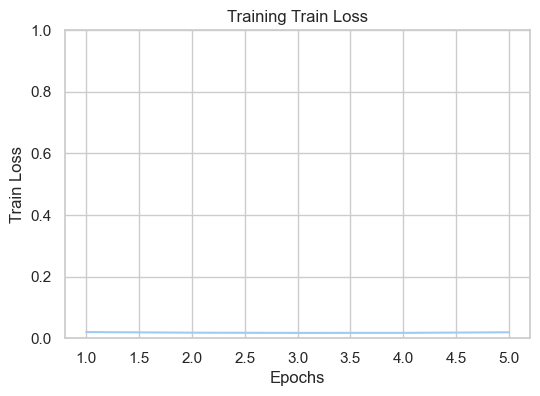

Standard Test


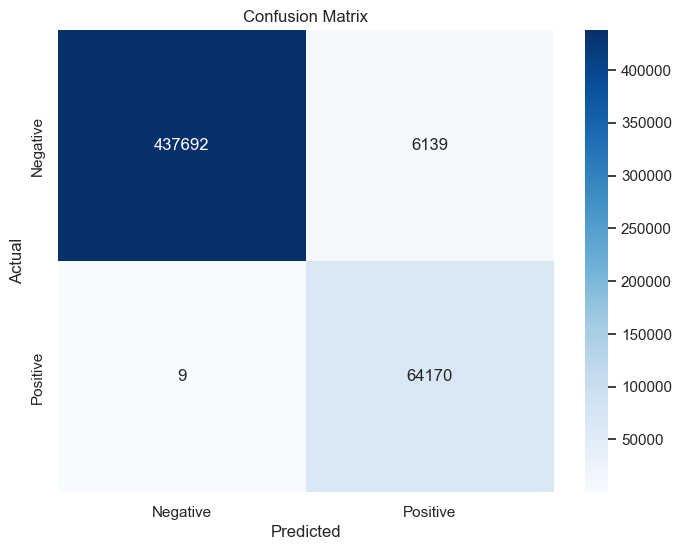

In [10]:
# Odd Errors? - didn't really encounter these before..
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/01-128'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
# This can be tuned to percentatage but we risk not classifying all threats.
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/5:   6%|▌         | 975/15876 [00:16<03:56, 63.07batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:   8%|▊         | 1343/15876 [00:22<03:54, 62.05batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  18%|█▊        | 2894/15876 [00:48<03:24, 63.34batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  29%|██▉       | 4604/15876 [01:19<03:10, 59.23batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  37%|███▋      | 5939/15876 [01:42<02:48, 58.85batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  39%|███▉      | 6177/15876 [01:47<02:52, 56.17batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  52%|█████▏    | 8297/15876 [02:24<02:07, 59.24batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  69%|██████▉   | 10950/15876 [03:11<01:21, 60.75batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  74%|███████▍  | 11757/15876 [03:25<01:13, 56.18batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  82%|████████▏ | 13014/15876 [03:47<00:48, 58.44batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  83%|████████▎ | 13168/15876 [03:50<00:48, 56.09batch/s]

Error running sampler. Using normal sample.


Epoch 1/5: 100%|██████████| 15876/15876 [04:38<00:00, 57.01batch/s]


Error running sampler. Using normal sample.
Epoch [1/5], Train Loss: 0.0205, Train Acc: 0.9917, Train F1: 0.9916


Epoch 2/5:   1%|▏         | 219/15876 [00:03<04:25, 59.05batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  15%|█▌        | 2434/15876 [00:43<03:54, 57.26batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  19%|█▉        | 3094/15876 [00:55<03:46, 56.41batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  23%|██▎       | 3584/15876 [01:03<03:23, 60.35batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  40%|███▉      | 6343/15876 [01:51<02:35, 61.11batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  44%|████▎     | 6939/15876 [02:02<02:41, 55.47batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  55%|█████▌    | 8751/15876 [02:34<01:59, 59.66batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  94%|█████████▍| 14988/15876 [04:22<00:15, 58.38batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  96%|█████████▌| 15170/15876 [04:25<00:12, 56.31batch/s]

Error running sampler. Using normal sample.


Epoch 2/5: 100%|██████████| 15876/15876 [04:38<00:00, 57.01batch/s]


Epoch [2/5], Train Loss: 0.0178, Train Acc: 0.9921, Train F1: 0.9921


Epoch 3/5:   4%|▎         | 585/15876 [00:10<04:13, 60.34batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  10%|▉         | 1573/15876 [00:27<04:01, 59.17batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  15%|█▍        | 2378/15876 [00:41<03:54, 57.57batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  20%|██        | 3202/15876 [00:56<03:34, 59.07batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  21%|██        | 3344/15876 [00:58<03:33, 58.70batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  32%|███▏      | 5021/15876 [01:28<03:05, 58.42batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  33%|███▎      | 5170/15876 [01:30<03:05, 57.83batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  51%|█████     | 8113/15876 [02:22<02:12, 58.81batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  51%|█████▏    | 8168/15876 [02:23<02:16, 56.33batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  57%|█████▋    | 9054/15876 [02:38<02:00, 56.79batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  66%|██████▌   | 10447/15876 [03:03<01:36, 56.01batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  73%|███████▎  | 11634/15876 [03:24<01:10, 60.00batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  77%|███████▋  | 12283/15876 [03:35<00:59, 59.91batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  81%|████████  | 12827/15876 [03:45<00:51, 59.59batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  82%|████████▏ | 12977/15876 [03:47<00:49, 58.25batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  91%|█████████▏| 14500/15876 [04:14<00:23, 59.41batch/s]

Error running sampler. Using normal sample.


Epoch 3/5: 100%|██████████| 15876/15876 [04:39<00:00, 56.90batch/s]


Epoch [3/5], Train Loss: 0.0196, Train Acc: 0.9923, Train F1: 0.9923


Epoch 4/5:   9%|▉         | 1429/15876 [00:25<04:08, 58.23batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  26%|██▋       | 4206/15876 [01:19<04:29, 43.27batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  45%|████▍     | 7097/15876 [02:16<02:35, 56.45batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  55%|█████▌    | 8754/15876 [02:45<02:00, 59.12batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  61%|██████    | 9647/15876 [03:00<01:46, 58.41batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  71%|███████   | 11245/15876 [03:29<01:22, 56.18batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  73%|███████▎  | 11569/15876 [03:34<01:16, 56.51batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  84%|████████▍ | 13383/15876 [04:07<00:44, 56.03batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  86%|████████▌ | 13646/15876 [04:11<00:39, 56.82batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  91%|█████████ | 14466/15876 [04:26<00:24, 58.30batch/s]

Error running sampler. Using normal sample.


Epoch 4/5: 100%|██████████| 15876/15876 [04:51<00:00, 54.52batch/s]


Epoch [4/5], Train Loss: 0.0177, Train Acc: 0.9921, Train F1: 0.9921


Epoch 5/5:   5%|▌         | 821/15876 [00:14<04:10, 60.00batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:   7%|▋         | 1125/15876 [00:20<04:14, 58.05batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:   9%|▉         | 1402/15876 [00:24<04:15, 56.75batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  11%|█         | 1706/15876 [00:30<04:12, 56.21batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  11%|█         | 1719/15876 [00:30<04:09, 56.81batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  19%|█▊        | 2948/15876 [00:52<03:59, 53.95batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  22%|██▏       | 3491/15876 [01:05<04:48, 42.92batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  27%|██▋       | 4208/15876 [01:21<04:24, 44.03batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  46%|████▌     | 7325/15876 [02:35<03:00, 47.44batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  50%|█████     | 7940/15876 [02:49<02:54, 45.59batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  53%|█████▎    | 8373/15876 [03:00<02:40, 46.62batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  54%|█████▎    | 8503/15876 [03:03<03:04, 39.99batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  62%|██████▏   | 9884/15876 [03:36<02:15, 44.09batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  66%|██████▌   | 10513/15876 [03:51<02:10, 41.24batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  70%|███████   | 11179/15876 [04:07<01:36, 48.88batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  94%|█████████▍| 14941/15876 [05:38<00:21, 43.37batch/s]

Error running sampler. Using normal sample.


Epoch 5/5: 100%|██████████| 15876/15876 [06:01<00:00, 43.89batch/s]


Error running sampler. Using normal sample.
Epoch [5/5], Train Loss: 0.0195, Train Acc: 0.9924, Train F1: 0.9924


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 320.36batch/s]

Test Loss: 0.0205, Test Accuracy: 0.9877, Test F1: 0.9881


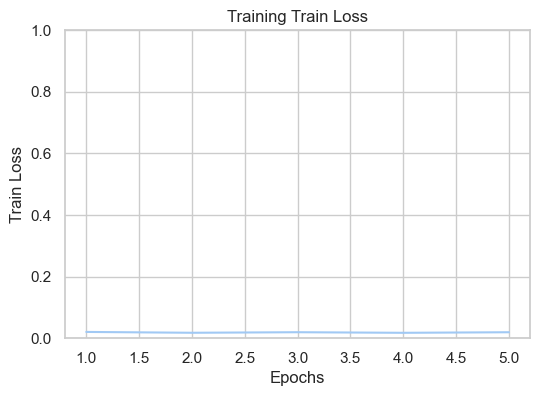

Standard Test


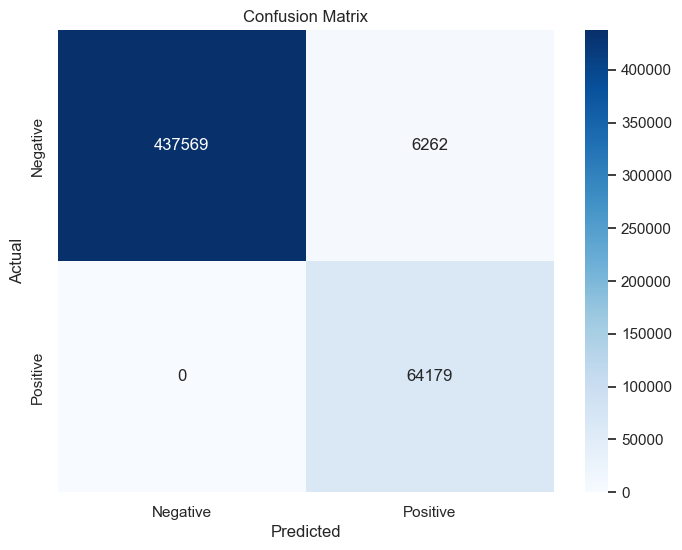

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/02/smote/01-256'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/5:  25%|██▍       | 3920/15876 [01:12<03:43, 53.49batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  30%|███       | 4821/15876 [01:29<03:38, 50.51batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  49%|████▊     | 7711/15876 [02:41<03:18, 41.11batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  54%|█████▎    | 8528/15876 [03:01<02:59, 40.99batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  71%|███████   | 11265/15876 [04:02<01:24, 54.33batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  91%|█████████ | 14411/15876 [05:14<00:31, 46.53batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  94%|█████████▎| 14846/15876 [05:24<00:23, 43.59batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  98%|█████████▊| 15534/15876 [05:40<00:07, 45.82batch/s]

Error running sampler. Using normal sample.


Epoch 1/5: 100%|██████████| 15876/15876 [05:49<00:00, 45.49batch/s]


Epoch [1/5], Train Loss: 0.0252, Train Acc: 0.9918, Train F1: 0.9918


Epoch 2/5:  18%|█▊        | 2782/15876 [01:04<04:53, 44.69batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  20%|█▉        | 3143/15876 [01:12<05:08, 41.32batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  21%|██        | 3290/15876 [01:15<04:46, 43.96batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  42%|████▏     | 6732/15876 [02:35<03:17, 46.18batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  62%|██████▏   | 9878/15876 [03:47<02:08, 46.50batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  71%|███████   | 11208/15876 [04:18<01:45, 44.29batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  73%|███████▎  | 11650/15876 [04:28<01:36, 44.01batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  85%|████████▍ | 13425/15876 [05:10<00:56, 43.18batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  93%|█████████▎| 14768/15876 [05:41<00:24, 45.44batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  95%|█████████▌| 15146/15876 [05:49<00:15, 47.44batch/s]

Error running sampler. Using normal sample.


Epoch 2/5: 100%|██████████| 15876/15876 [06:06<00:00, 43.29batch/s]


Error running sampler. Using normal sample.
Epoch [2/5], Train Loss: 0.0173, Train Acc: 0.9918, Train F1: 0.9918


Epoch 3/5:   1%|          | 139/15876 [00:03<06:13, 42.08batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:   3%|▎         | 532/15876 [00:12<06:05, 42.00batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:   9%|▉         | 1448/15876 [00:34<05:16, 45.60batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  16%|█▌        | 2563/15876 [01:00<05:11, 42.68batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  25%|██▌       | 3983/15876 [01:33<04:14, 46.78batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  37%|███▋      | 5896/15876 [02:18<03:46, 44.11batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  45%|████▍     | 7098/15876 [02:47<02:50, 51.48batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  51%|█████▏    | 8159/15876 [03:06<02:17, 56.09batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  52%|█████▏    | 8303/15876 [03:09<02:15, 55.89batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  61%|██████    | 9649/15876 [03:33<01:51, 55.84batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  91%|█████████ | 14473/15876 [05:00<00:25, 56.10batch/s]

Error running sampler. Using normal sample.


Epoch 3/5: 100%|██████████| 15876/15876 [05:26<00:00, 48.65batch/s]


Epoch [3/5], Train Loss: 0.0178, Train Acc: 0.9920, Train F1: 0.9920


Epoch 4/5:   7%|▋         | 1092/15876 [00:19<04:22, 56.29batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  36%|███▌      | 5703/15876 [01:44<03:06, 54.49batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  46%|████▌     | 7232/15876 [02:13<02:34, 55.77batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  58%|█████▊    | 9129/15876 [02:48<01:58, 56.93batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  65%|██████▌   | 10356/15876 [03:11<01:43, 53.37batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  78%|███████▊  | 12457/15876 [03:50<01:04, 52.70batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  80%|███████▉  | 12693/15876 [03:54<00:56, 56.08batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  88%|████████▊ | 13945/15876 [04:17<00:35, 54.76batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  97%|█████████▋| 15402/15876 [04:44<00:08, 56.39batch/s]

Error running sampler. Using normal sample.


Epoch 4/5: 100%|██████████| 15876/15876 [04:53<00:00, 54.04batch/s]


Error running sampler. Using normal sample.
Error running sampler. Using normal sample.
Epoch [4/5], Train Loss: 0.0192, Train Acc: 0.9922, Train F1: 0.9922


Epoch 5/5:  19%|█▊        | 2960/15876 [00:55<03:59, 53.89batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  30%|███       | 4837/15876 [01:30<03:18, 55.52batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  32%|███▏      | 5133/15876 [01:36<03:21, 53.18batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  54%|█████▎    | 8528/15876 [02:40<02:17, 53.61batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  59%|█████▊    | 9317/15876 [02:55<02:00, 54.47batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  65%|██████▌   | 10368/15876 [03:15<01:41, 54.09batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  92%|█████████▏| 14586/15876 [04:34<00:23, 53.97batch/s]

Error running sampler. Using normal sample.


Epoch 5/5: 100%|██████████| 15876/15876 [04:59<00:00, 53.09batch/s]


Error running sampler. Using normal sample.
Epoch [5/5], Train Loss: 0.0180, Train Acc: 0.9920, Train F1: 0.9920


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 297.68batch/s]


Test Loss: 0.0273, Test Accuracy: 0.9878, Test F1: 0.9882


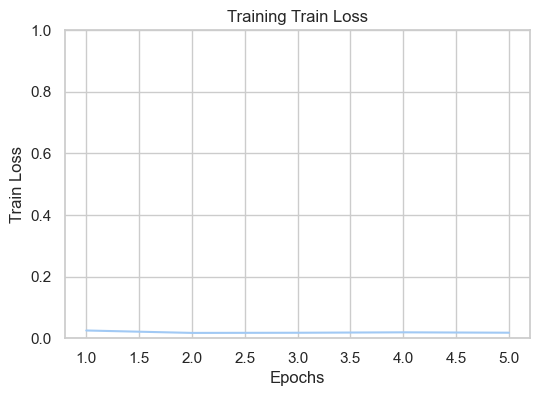

Standard Test


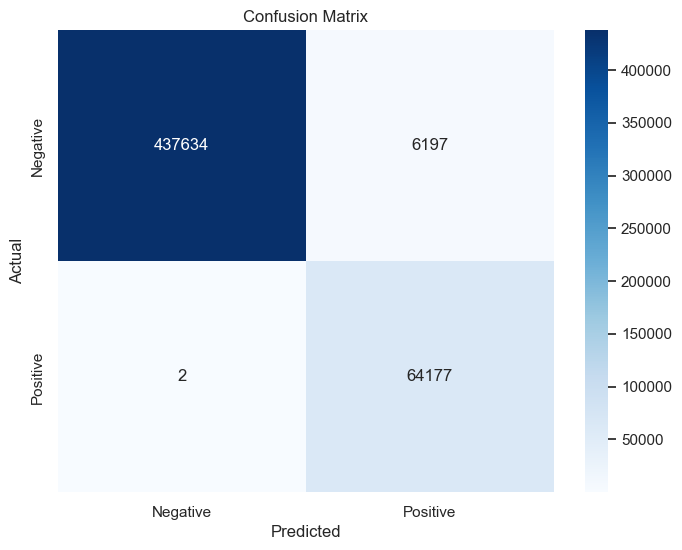

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/smote/01-512'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

LR and Epochs

Epoch 1/5:   2%|▏         | 390/15876 [00:06<03:56, 65.43batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  34%|███▍      | 5464/15876 [01:28<02:50, 60.97batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  40%|███▉      | 6329/15876 [01:42<02:28, 64.43batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  45%|████▍     | 7110/15876 [01:54<02:16, 64.36batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  54%|█████▍    | 8545/15876 [02:17<01:55, 63.21batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  60%|█████▉    | 9475/15876 [02:32<01:43, 61.76batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  62%|██████▏   | 9920/15876 [02:39<01:37, 61.24batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  73%|███████▎  | 11643/15876 [03:06<01:07, 62.76batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  74%|███████▍  | 11750/15876 [03:08<01:03, 64.85batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  78%|███████▊  | 12313/15876 [03:17<00:56, 63.32batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  88%|████████▊ | 13939/15876 [03:43<00:30, 64.46batch/s]

Error running sampler. Using normal sample.


Epoch 1/5:  93%|█████████▎| 14830/15876 [03:57<00:16, 63.32batch/s]

Error running sampler. Using normal sample.


Epoch 1/5: 100%|██████████| 15876/15876 [04:14<00:00, 62.48batch/s]


Error running sampler. Using normal sample.
Epoch [1/5], Train Loss: 0.0195, Train Acc: 0.9917, Train F1: 0.9917


Epoch 2/5:   4%|▍         | 704/15876 [00:11<03:58, 63.49batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  29%|██▉       | 4661/15876 [01:13<02:49, 66.29batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  37%|███▋      | 5871/15876 [01:32<02:34, 64.85batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  41%|████▏     | 6563/15876 [01:43<02:22, 65.46batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  49%|████▉     | 7757/15876 [02:02<02:13, 60.92batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  49%|████▉     | 7842/15876 [02:03<02:03, 64.83batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  52%|█████▏    | 8267/15876 [02:10<01:53, 67.14batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  65%|██████▍   | 10257/15876 [02:41<01:23, 67.57batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  71%|███████   | 11233/15876 [02:56<01:09, 67.23batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  75%|███████▌  | 11928/15876 [03:07<01:01, 64.65batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  80%|████████  | 12733/15876 [03:20<00:47, 65.61batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  81%|████████  | 12804/15876 [03:21<00:48, 63.62batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  89%|████████▉ | 14148/15876 [03:43<00:26, 65.58batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  91%|█████████▏| 14514/15876 [03:48<00:21, 64.16batch/s]

Error running sampler. Using normal sample.


Epoch 2/5:  97%|█████████▋| 15351/15876 [04:02<00:08, 61.57batch/s]

Error running sampler. Using normal sample.


Epoch 2/5: 100%|██████████| 15876/15876 [04:10<00:00, 63.41batch/s]


Epoch [2/5], Train Loss: 0.0172, Train Acc: 0.9919, Train F1: 0.9919


Epoch 3/5:   6%|▌         | 984/15876 [00:15<03:58, 62.53batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:   8%|▊         | 1274/15876 [00:20<03:43, 65.29batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  13%|█▎        | 2126/15876 [00:33<03:27, 66.34batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  34%|███▍      | 5377/15876 [01:24<02:36, 67.18batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  41%|████      | 6533/15876 [01:42<02:26, 63.68batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  42%|████▏     | 6731/15876 [01:45<02:24, 63.15batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  44%|████▍     | 6976/15876 [01:49<02:19, 63.90batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  57%|█████▋    | 9102/15876 [02:24<01:41, 66.68batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  70%|███████   | 11142/15876 [02:56<01:14, 63.54batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  76%|███████▋  | 12140/15876 [03:12<00:57, 64.86batch/s]

Error running sampler. Using normal sample.


Epoch 3/5:  98%|█████████▊| 15575/15876 [04:20<00:05, 57.57batch/s]

Error running sampler. Using normal sample.


Epoch 3/5: 100%|██████████| 15876/15876 [04:25<00:00, 59.86batch/s]


Error running sampler. Using normal sample.
Epoch [3/5], Train Loss: 0.0177, Train Acc: 0.9919, Train F1: 0.9919


Epoch 4/5:  26%|██▌       | 4135/15876 [01:07<03:16, 59.75batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  42%|████▏     | 6652/15876 [01:47<02:24, 63.75batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  44%|████▍     | 7058/15876 [01:54<02:20, 62.73batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  45%|████▍     | 7140/15876 [01:55<02:23, 60.69batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  48%|████▊     | 7601/15876 [02:03<02:16, 60.47batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  58%|█████▊    | 9163/15876 [02:29<01:51, 60.18batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  62%|██████▏   | 9876/15876 [02:42<01:40, 59.82batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  62%|██████▏   | 9917/15876 [02:42<01:36, 61.56batch/s]

Error running sampler. Using normal sample.


Epoch 4/5:  96%|█████████▌| 15198/15876 [04:09<00:10, 62.77batch/s]

Error running sampler. Using normal sample.


Epoch 4/5: 100%|██████████| 15876/15876 [04:20<00:00, 60.91batch/s]


Error running sampler. Using normal sample.
Epoch [4/5], Train Loss: 0.0167, Train Acc: 0.9920, Train F1: 0.9920


Epoch 5/5:  20%|██        | 3187/15876 [00:51<03:30, 60.35batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  21%|██        | 3286/15876 [00:53<03:19, 62.95batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  24%|██▍       | 3799/15876 [01:01<03:02, 66.23batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  35%|███▍      | 5494/15876 [01:28<02:46, 62.23batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  35%|███▍      | 5527/15876 [01:29<02:49, 60.98batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  39%|███▊      | 6128/15876 [01:39<02:30, 64.96batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  49%|████▉     | 7820/15876 [02:06<02:07, 63.23batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  52%|█████▏    | 8289/15876 [02:14<01:58, 64.19batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  58%|█████▊    | 9130/15876 [02:27<01:48, 62.34batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  59%|█████▉    | 9339/15876 [02:31<01:43, 63.23batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  66%|██████▌   | 10456/15876 [02:49<01:25, 63.63batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  69%|██████▊   | 10890/15876 [02:56<01:20, 62.29batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  80%|████████  | 12753/15876 [03:27<00:49, 63.65batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  92%|█████████▏| 14591/15876 [03:56<00:19, 65.37batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  97%|█████████▋| 15448/15876 [04:10<00:06, 64.17batch/s]

Error running sampler. Using normal sample.


Epoch 5/5:  99%|█████████▉| 15766/15876 [04:15<00:01, 63.50batch/s]

Error running sampler. Using normal sample.


Epoch 5/5: 100%|██████████| 15876/15876 [04:17<00:00, 61.60batch/s]


Error running sampler. Using normal sample.
Epoch [5/5], Train Loss: 0.0188, Train Acc: 0.9920, Train F1: 0.9920


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 336.75batch/s]

Test Loss: 0.0193, Test Accuracy: 0.9876, Test F1: 0.9880


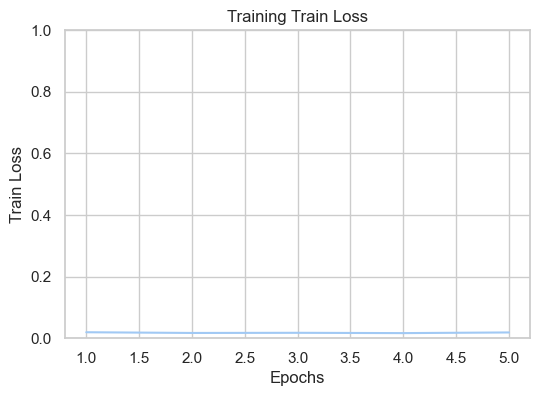

Standard Test


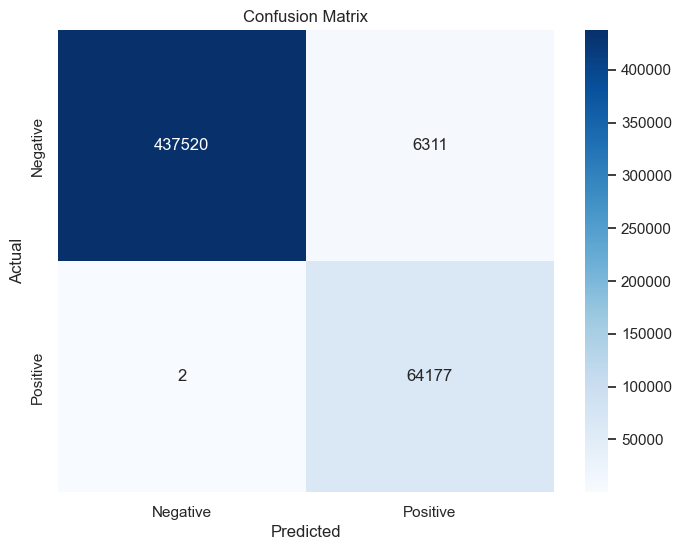

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/009-128'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.09
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/15:  17%|█▋        | 2757/15876 [00:59<05:24, 40.49batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  31%|███▏      | 4980/15876 [02:00<04:56, 36.80batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  43%|████▎     | 6751/15876 [02:49<03:56, 38.62batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  43%|████▎     | 6797/15876 [02:50<03:58, 38.07batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  43%|████▎     | 6887/15876 [02:52<03:59, 37.56batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  53%|█████▎    | 8468/15876 [03:35<03:15, 37.98batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  66%|██████▌   | 10455/15876 [04:27<02:17, 39.55batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  69%|██████▊   | 10898/15876 [04:38<02:11, 37.88batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  79%|███████▉  | 12521/15876 [05:21<01:26, 38.89batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  80%|███████▉  | 12650/15876 [05:24<01:21, 39.71batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  80%|███████▉  | 12687/15876 [05:25<01:22, 38.69batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  85%|████████▌ | 13517/15876 [05:47<00:58, 40.65batch/s]

Error running sampler. Using normal sample.


Epoch 1/15: 100%|██████████| 15876/15876 [06:51<00:00, 38.62batch/s]


Error running sampler. Using normal sample.
Epoch [1/15], Train Loss: 0.0178, Train Acc: 0.9917, Train F1: 0.9917


Epoch 2/15:  14%|█▎        | 2182/15876 [00:58<05:53, 38.76batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  29%|██▉       | 4669/15876 [02:05<05:01, 37.23batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  30%|██▉       | 4693/15876 [02:05<05:00, 37.25batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  51%|█████     | 8112/15876 [03:39<03:31, 36.77batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  66%|██████▌   | 10413/15876 [04:44<02:28, 36.84batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  67%|██████▋   | 10674/15876 [04:51<02:22, 36.51batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  71%|███████▏  | 11329/15876 [05:10<02:10, 34.71batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  82%|████████▏ | 13021/15876 [05:56<01:13, 38.86batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  87%|████████▋ | 13787/15876 [06:16<00:54, 38.68batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  90%|█████████ | 14361/15876 [06:31<00:38, 39.11batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  95%|█████████▌| 15146/15876 [06:53<00:20, 36.36batch/s]

Error running sampler. Using normal sample.


Epoch 2/15: 100%|██████████| 15876/15876 [07:14<00:00, 36.56batch/s]


Error running sampler. Using normal sample.
Epoch [2/15], Train Loss: 0.0160, Train Acc: 0.9919, Train F1: 0.9919


Epoch 3/15:   1%|          | 81/15876 [00:02<07:23, 35.64batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  12%|█▏        | 1902/15876 [00:54<06:34, 35.39batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  23%|██▎       | 3718/15876 [01:46<05:42, 35.54batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  25%|██▌       | 4010/15876 [01:54<05:34, 35.52batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  28%|██▊       | 4407/15876 [02:06<05:10, 36.89batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  32%|███▏      | 5076/15876 [02:25<05:06, 35.27batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  33%|███▎      | 5216/15876 [02:29<04:59, 35.62batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  39%|███▉      | 6212/15876 [02:57<04:25, 36.43batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  75%|███████▍  | 11889/15876 [05:41<01:50, 35.98batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  84%|████████▍ | 13374/15876 [06:24<01:10, 35.59batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  87%|████████▋ | 13887/15876 [06:38<00:57, 34.78batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  89%|████████▉ | 14160/15876 [06:46<00:47, 36.12batch/s]

Error running sampler. Using normal sample.


Epoch 3/15: 100%|██████████| 15876/15876 [07:36<00:00, 34.74batch/s]


Epoch [3/15], Train Loss: 0.0172, Train Acc: 0.9922, Train F1: 0.9922


Epoch 4/15:  10%|█         | 1646/15876 [00:47<06:24, 36.96batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  16%|█▌        | 2563/15876 [01:14<06:16, 35.38batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  20%|█▉        | 3147/15876 [01:31<05:53, 36.05batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  37%|███▋      | 5907/15876 [02:51<04:38, 35.85batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  39%|███▉      | 6172/15876 [02:59<04:32, 35.66batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  44%|████▍     | 6984/15876 [03:22<04:09, 35.57batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  45%|████▍     | 7104/15876 [03:26<04:07, 35.38batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  47%|████▋     | 7473/15876 [03:37<03:59, 35.06batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  67%|██████▋   | 10679/15876 [05:11<02:22, 36.40batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  68%|██████▊   | 10803/15876 [05:15<02:27, 34.49batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  96%|█████████▌| 15207/15876 [07:24<00:19, 34.73batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  97%|█████████▋| 15471/15876 [07:32<00:11, 34.34batch/s]

Error running sampler. Using normal sample.


Epoch 4/15: 100%|██████████| 15876/15876 [07:44<00:00, 34.20batch/s]


Error running sampler. Using normal sample.
Epoch [4/15], Train Loss: 0.0175, Train Acc: 0.9923, Train F1: 0.9923


Epoch 5/15:  14%|█▎        | 2165/15876 [01:04<06:41, 34.13batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  14%|█▍        | 2301/15876 [01:07<06:34, 34.43batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  23%|██▎       | 3705/15876 [01:49<05:59, 33.85batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  30%|██▉       | 4721/15876 [02:19<05:22, 34.58batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  36%|███▋      | 5761/15876 [02:50<04:52, 34.52batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  51%|█████     | 8049/15876 [03:58<03:53, 33.52batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  52%|█████▏    | 8314/15876 [04:06<03:32, 35.53batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  56%|█████▌    | 8890/15876 [04:23<03:26, 33.88batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  61%|██████    | 9718/15876 [04:48<02:56, 34.89batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  73%|███████▎  | 11566/15876 [05:43<02:11, 32.89batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  88%|████████▊ | 13958/15876 [06:55<00:54, 35.07batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  96%|█████████▋| 15310/15876 [07:36<00:16, 34.98batch/s]

Error running sampler. Using normal sample.


Epoch 5/15: 100%|██████████| 15876/15876 [07:52<00:00, 33.57batch/s]


Error running sampler. Using normal sample.
Epoch [5/15], Train Loss: 0.0179, Train Acc: 0.9923, Train F1: 0.9923


Epoch 6/15:   7%|▋         | 1109/15876 [00:33<07:07, 34.51batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  20%|█▉        | 3157/15876 [01:34<06:16, 33.81batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  20%|█▉        | 3173/15876 [01:34<06:06, 34.70batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  40%|████      | 6369/15876 [03:10<04:40, 33.93batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  83%|████████▎ | 13117/15876 [06:32<01:20, 34.33batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  92%|█████████▏| 14537/15876 [07:14<00:39, 33.85batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  94%|█████████▍| 14973/15876 [07:27<00:26, 33.62batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  95%|█████████▌| 15085/15876 [07:31<00:22, 34.62batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  95%|█████████▌| 15157/15876 [07:33<00:19, 35.97batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  99%|█████████▉| 15757/15876 [07:51<00:03, 33.33batch/s]

Error running sampler. Using normal sample.


Epoch 6/15: 100%|██████████| 15876/15876 [07:55<00:00, 33.42batch/s]


Error running sampler. Using normal sample.
Epoch [6/15], Train Loss: 0.0187, Train Acc: 0.9925, Train F1: 0.9925


Epoch 7/15:  24%|██▍       | 3777/15876 [01:50<05:12, 38.77batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  26%|██▌       | 4091/15876 [01:58<05:17, 37.17batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  39%|███▉      | 6257/15876 [02:59<04:27, 35.95batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  59%|█████▊    | 9297/15876 [04:24<02:57, 37.05batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  86%|████████▌ | 13613/15876 [06:23<01:02, 36.07batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  89%|████████▉ | 14147/15876 [06:38<00:47, 36.64batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  97%|█████████▋| 15381/15876 [07:13<00:13, 36.44batch/s]

Error running sampler. Using normal sample.


Epoch 7/15: 100%|██████████| 15876/15876 [07:26<00:00, 35.52batch/s]


Error running sampler. Using normal sample.
Epoch [7/15], Train Loss: 0.0183, Train Acc: 0.9923, Train F1: 0.9923


Epoch 8/15:  43%|████▎     | 6858/15876 [03:08<04:02, 37.18batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  55%|█████▌    | 8766/15876 [04:00<03:14, 36.51batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  68%|██████▊   | 10729/15876 [04:53<02:13, 38.55batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  84%|████████▍ | 13344/15876 [06:04<01:09, 36.26batch/s]

Error running sampler. Using normal sample.


Epoch 8/15: 100%|██████████| 15876/15876 [07:14<00:00, 36.50batch/s]


Error running sampler. Using normal sample.
Epoch [8/15], Train Loss: 0.0172, Train Acc: 0.9922, Train F1: 0.9922


Epoch 9/15:   9%|▉         | 1396/15876 [00:38<06:26, 37.45batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  21%|██▏       | 3380/15876 [01:32<05:37, 37.01batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  22%|██▏       | 3512/15876 [01:35<05:30, 37.36batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  26%|██▌       | 4107/15876 [01:52<05:14, 37.43batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  30%|██▉       | 4737/15876 [02:09<04:54, 37.84batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  34%|███▎      | 5341/15876 [02:25<04:38, 37.78batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  42%|████▏     | 6669/15876 [03:02<04:01, 38.12batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  60%|██████    | 9603/15876 [04:22<02:45, 38.00batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  68%|██████▊   | 10802/15876 [04:55<02:11, 38.60batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  93%|█████████▎| 14766/15876 [06:40<00:29, 37.37batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  97%|█████████▋| 15336/15876 [06:55<00:13, 38.60batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  98%|█████████▊| 15483/15876 [06:59<00:09, 40.11batch/s]

Error running sampler. Using normal sample.


Epoch 9/15: 100%|██████████| 15876/15876 [07:10<00:00, 36.91batch/s]


Error running sampler. Using normal sample.
Epoch [9/15], Train Loss: 0.0191, Train Acc: 0.9926, Train F1: 0.9926


Epoch 10/15:  11%|█         | 1783/15876 [00:47<06:12, 37.81batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  12%|█▏        | 1830/15876 [00:48<05:55, 39.54batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  18%|█▊        | 2934/15876 [01:17<05:34, 38.67batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  21%|██        | 3262/15876 [01:26<05:21, 39.21batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  22%|██▏       | 3418/15876 [01:30<05:06, 40.63batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  24%|██▍       | 3842/15876 [01:41<04:58, 40.31batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  26%|██▌       | 4060/15876 [01:47<05:03, 38.99batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  31%|███       | 4877/15876 [02:09<04:48, 38.12batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  33%|███▎      | 5279/15876 [02:19<04:19, 40.85batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  69%|██████▉   | 11033/15876 [04:50<02:06, 38.18batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  73%|███████▎  | 11657/15876 [05:07<01:47, 39.38batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  75%|███████▌  | 11979/15876 [05:16<01:52, 34.76batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  79%|███████▉  | 12526/15876 [05:30<01:25, 39.28batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  81%|████████  | 12800/15876 [05:38<01:21, 37.78batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  86%|████████▋ | 13698/15876 [06:01<00:54, 39.95batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  88%|████████▊ | 13944/15876 [06:08<00:50, 38.06batch/s]

Error running sampler. Using normal sample.


Epoch 10/15: 100%|█████████▉| 15803/15876 [06:46<00:01, 61.86batch/s]

Error running sampler. Using normal sample.


Epoch 10/15: 100%|██████████| 15876/15876 [06:47<00:00, 38.91batch/s]


Epoch [10/15], Train Loss: 0.0180, Train Acc: 0.9922, Train F1: 0.9922


Epoch 11/15:  25%|██▍       | 3948/15876 [01:43<05:08, 38.62batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  30%|███       | 4804/15876 [02:06<04:52, 37.88batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  39%|███▉      | 6221/15876 [02:45<04:04, 39.49batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  59%|█████▊    | 9298/15876 [04:10<02:55, 37.40batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  76%|███████▋  | 12135/15876 [04:57<00:58, 63.65batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  81%|████████▏ | 12900/15876 [05:09<00:45, 65.70batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  82%|████████▏ | 13055/15876 [05:12<00:45, 62.51batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  83%|████████▎ | 13162/15876 [05:14<00:41, 66.18batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  86%|████████▌ | 13667/15876 [05:22<00:34, 63.67batch/s]

Error running sampler. Using normal sample.


Epoch 11/15: 100%|█████████▉| 15868/15876 [05:57<00:00, 62.74batch/s]

Error running sampler. Using normal sample.


Epoch 11/15: 100%|██████████| 15876/15876 [05:58<00:00, 44.34batch/s]


Error running sampler. Using normal sample.
Epoch [11/15], Train Loss: 0.0192, Train Acc: 0.9924, Train F1: 0.9924


Epoch 12/15:   4%|▍         | 666/15876 [00:10<04:12, 60.18batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:   5%|▍         | 749/15876 [00:12<03:56, 64.00batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  13%|█▎        | 2073/15876 [00:33<03:47, 60.64batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  14%|█▎        | 2150/15876 [00:34<03:29, 65.56batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  18%|█▊        | 2791/15876 [00:45<03:26, 63.38batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  20%|█▉        | 3101/15876 [00:50<03:23, 62.64batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  22%|██▏       | 3503/15876 [00:56<03:28, 59.44batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  23%|██▎       | 3639/15876 [00:59<03:28, 58.64batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  44%|████▍     | 7064/15876 [01:54<02:14, 65.64batch/s]

Error running sampler. Using normal sample.
Error running sampler. Using normal sample.


Epoch 12/15:  72%|███████▏  | 11380/15876 [03:06<01:08, 65.33batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  92%|█████████▏| 14667/15876 [04:00<00:18, 64.10batch/s]

Error running sampler. Using normal sample.
Error running sampler. Using normal sample.


Epoch 12/15:  95%|█████████▌| 15147/15876 [04:08<00:11, 62.13batch/s]

Error running sampler. Using normal sample.


Epoch 12/15: 100%|██████████| 15876/15876 [04:20<00:00, 60.92batch/s]


Epoch [12/15], Train Loss: 0.0182, Train Acc: 0.9925, Train F1: 0.9925


Epoch 13/15:   3%|▎         | 540/15876 [00:12<06:59, 36.53batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  26%|██▌       | 4057/15876 [01:46<05:27, 36.08batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  28%|██▊       | 4513/15876 [01:58<04:53, 38.78batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  54%|█████▍    | 8537/15876 [03:40<02:23, 51.16batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  57%|█████▋    | 9074/15876 [03:52<02:30, 45.27batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  67%|██████▋   | 10572/15876 [04:27<01:56, 45.68batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  69%|██████▊   | 10914/15876 [04:34<01:45, 47.21batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  75%|███████▌  | 11955/15876 [04:58<01:26, 45.07batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  91%|█████████ | 14436/15876 [05:47<00:22, 64.06batch/s]

Error running sampler. Using normal sample.


Epoch 13/15: 100%|██████████| 15876/15876 [06:11<00:00, 42.72batch/s]


Error running sampler. Using normal sample.
Epoch [13/15], Train Loss: 0.0174, Train Acc: 0.9921, Train F1: 0.9920


Epoch 14/15:   2%|▏         | 348/15876 [00:05<04:04, 63.41batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  13%|█▎        | 2022/15876 [00:33<03:46, 61.16batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  18%|█▊        | 2842/15876 [00:46<03:33, 61.02batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  28%|██▊       | 4452/15876 [01:12<03:14, 58.88batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  36%|███▌      | 5679/15876 [01:32<02:37, 64.65batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  42%|████▏     | 6663/15876 [01:55<03:32, 43.34batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  42%|████▏     | 6705/15876 [01:55<03:09, 48.37batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  43%|████▎     | 6889/15876 [01:59<03:23, 44.17batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  62%|██████▏   | 9768/15876 [02:55<01:38, 62.16batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  72%|███████▏  | 11392/15876 [03:21<01:09, 64.37batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  72%|███████▏  | 11470/15876 [03:22<01:11, 61.80batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  74%|███████▍  | 11741/15876 [03:27<01:05, 62.98batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  90%|████████▉ | 14224/15876 [04:29<00:45, 36.43batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  99%|█████████▉| 15785/15876 [05:12<00:02, 37.24batch/s]

Error running sampler. Using normal sample.


Epoch 14/15: 100%|██████████| 15876/15876 [05:14<00:00, 50.44batch/s]


Epoch [14/15], Train Loss: 0.0180, Train Acc: 0.9921, Train F1: 0.9921


Epoch 15/15:  38%|███▊      | 6051/15876 [02:43<04:18, 38.05batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  39%|███▊      | 6129/15876 [02:45<04:28, 36.33batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  58%|█████▊    | 9257/15876 [04:10<02:54, 38.01batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  79%|███████▉  | 12620/15876 [05:41<01:24, 38.68batch/s]

Error running sampler. Using normal sample.


Epoch 15/15: 100%|██████████| 15876/15876 [06:53<00:00, 38.40batch/s]


Error running sampler. Using normal sample.
Epoch [15/15], Train Loss: 0.0177, Train Acc: 0.9920, Train F1: 0.9920


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 325.98batch/s]


Test Loss: 0.0217, Test Accuracy: 0.9879, Test F1: 0.9883


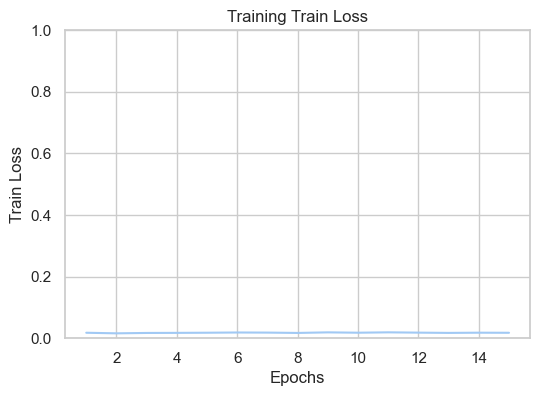

Standard Test


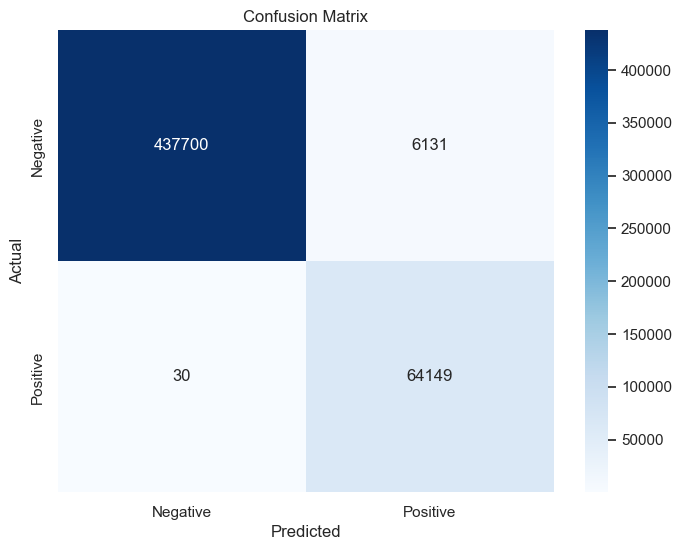

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/008-256'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.08
epochs = 15
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Epoch 1/15:  10%|█         | 1643/15876 [00:25<03:37, 65.54batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  14%|█▍        | 2203/15876 [00:34<03:33, 64.03batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  42%|████▏     | 6617/15876 [01:44<02:21, 65.49batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  44%|████▍     | 7051/15876 [01:50<02:14, 65.39batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  45%|████▍     | 7122/15876 [01:51<02:11, 66.76batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  57%|█████▋    | 9128/15876 [02:23<01:44, 64.74batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  74%|███████▎  | 11683/15876 [03:03<01:05, 64.24batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  81%|████████  | 12840/15876 [03:22<00:47, 64.19batch/s]

Error running sampler. Using normal sample.


Epoch 1/15:  98%|█████████▊| 15525/15876 [04:05<00:05, 60.40batch/s]

Error running sampler. Using normal sample.


Epoch 1/15: 100%|██████████| 15876/15876 [04:11<00:00, 63.09batch/s]


Epoch [1/15], Train Loss: 0.0175, Train Acc: 0.9919, Train F1: 0.9919


Epoch 2/15:  23%|██▎       | 3610/15876 [00:58<03:09, 64.59batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  44%|████▍     | 7053/15876 [01:53<02:15, 65.08batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  66%|██████▋   | 10541/15876 [02:48<01:25, 62.61batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  68%|██████▊   | 10800/15876 [02:52<01:18, 64.83batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  71%|███████   | 11224/15876 [02:59<01:12, 63.90batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  80%|███████▉  | 12648/15876 [03:21<00:51, 62.71batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  90%|█████████ | 14298/15876 [03:48<00:25, 61.97batch/s]

Error running sampler. Using normal sample.


Epoch 2/15:  97%|█████████▋| 15352/15876 [04:05<00:08, 61.48batch/s]

Error running sampler. Using normal sample.


Epoch 2/15: 100%|██████████| 15876/15876 [04:14<00:00, 62.49batch/s]


Epoch [2/15], Train Loss: 0.0157, Train Acc: 0.9920, Train F1: 0.9920


Epoch 3/15:  10%|█         | 1589/15876 [00:25<03:54, 60.93batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  24%|██▍       | 3807/15876 [01:01<03:11, 63.11batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  35%|███▌      | 5569/15876 [01:30<02:49, 60.66batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  35%|███▌      | 5610/15876 [01:30<02:51, 59.77batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  45%|████▌     | 7162/15876 [01:56<02:24, 60.46batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  55%|█████▍    | 8726/15876 [02:23<02:03, 58.02batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  65%|██████▌   | 10376/15876 [02:50<01:32, 59.48batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  67%|██████▋   | 10566/15876 [02:54<01:23, 63.54batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  78%|███████▊  | 12349/15876 [03:22<00:56, 62.35batch/s]

Error running sampler. Using normal sample.
Error running sampler. Using normal sample.


Epoch 3/15:  78%|███████▊  | 12419/15876 [03:23<00:54, 63.38batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  81%|████████  | 12801/15876 [03:29<00:47, 64.61batch/s]

Error running sampler. Using normal sample.


Epoch 3/15:  82%|████████▏ | 13014/15876 [03:32<00:44, 64.70batch/s]

Error running sampler. Using normal sample.


Epoch 3/15: 100%|██████████| 15876/15876 [04:32<00:00, 58.33batch/s]


Error running sampler. Using normal sample.
Epoch [3/15], Train Loss: 0.0154, Train Acc: 0.9921, Train F1: 0.9921


Epoch 4/15:   0%|          | 36/15876 [00:00<05:42, 46.29batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  14%|█▍        | 2294/15876 [00:44<03:35, 62.98batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  23%|██▎       | 3698/15876 [01:06<03:07, 64.88batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  25%|██▌       | 4048/15876 [01:12<03:10, 62.22batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  64%|██████▍   | 10226/15876 [02:51<01:27, 64.47batch/s]

Error running sampler. Using normal sample.


Epoch 4/15:  87%|████████▋ | 13769/15876 [03:48<00:31, 67.02batch/s]

Error running sampler. Using normal sample.


Epoch 4/15: 100%|██████████| 15876/15876 [04:22<00:00, 60.45batch/s]


Error running sampler. Using normal sample.
Epoch [4/15], Train Loss: 0.0169, Train Acc: 0.9924, Train F1: 0.9924


Epoch 5/15:  11%|█         | 1703/15876 [00:27<03:45, 62.92batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  14%|█▍        | 2230/15876 [00:35<03:41, 61.61batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  16%|█▌        | 2570/15876 [00:41<03:28, 63.69batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  34%|███▍      | 5392/15876 [01:26<02:43, 64.04batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  42%|████▏     | 6616/15876 [01:46<02:26, 63.03batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  44%|████▍     | 7011/15876 [01:52<02:23, 61.92batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  48%|████▊     | 7669/15876 [02:03<02:12, 61.84batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  68%|██████▊   | 10839/15876 [02:54<01:20, 62.71batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  73%|███████▎  | 11539/15876 [03:05<01:06, 64.76batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  84%|████████▍ | 13316/15876 [03:34<00:39, 64.73batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  87%|████████▋ | 13801/15876 [03:42<00:33, 62.52batch/s]

Error running sampler. Using normal sample.


Epoch 5/15:  92%|█████████▏| 14540/15876 [03:54<00:21, 61.01batch/s]

Error running sampler. Using normal sample.


Epoch 5/15: 100%|██████████| 15876/15876 [04:15<00:00, 62.05batch/s]


Epoch [5/15], Train Loss: 0.0176, Train Acc: 0.9921, Train F1: 0.9921


Epoch 6/15:  21%|██        | 3325/15876 [00:53<03:09, 66.16batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  30%|███       | 4833/15876 [01:18<03:28, 53.09batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  31%|███▏      | 4996/15876 [01:21<02:53, 62.71batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  36%|███▌      | 5640/15876 [01:31<02:33, 66.80batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  64%|██████▍   | 10169/15876 [02:45<01:32, 61.76batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  67%|██████▋   | 10641/15876 [02:52<01:21, 64.47batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  77%|███████▋  | 12293/15876 [03:19<00:56, 62.96batch/s]

Error running sampler. Using normal sample.


Epoch 6/15:  94%|█████████▍| 14949/15876 [04:02<00:14, 65.33batch/s]

Error running sampler. Using normal sample.


Epoch 6/15: 100%|██████████| 15876/15876 [04:17<00:00, 61.75batch/s]


Epoch [6/15], Train Loss: 0.0161, Train Acc: 0.9923, Train F1: 0.9923


Epoch 7/15:  12%|█▏        | 1841/15876 [00:29<03:39, 63.84batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  13%|█▎        | 2006/15876 [00:32<03:25, 67.53batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  33%|███▎      | 5222/15876 [01:23<02:50, 62.60batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  36%|███▌      | 5660/15876 [01:30<02:49, 60.41batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  49%|████▊     | 7726/15876 [02:03<02:09, 63.11batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  58%|█████▊    | 9178/15876 [02:27<01:51, 60.25batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  72%|███████▏  | 11475/15876 [03:04<01:09, 63.07batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  75%|███████▌  | 11972/15876 [03:12<01:00, 64.29batch/s]

Error running sampler. Using normal sample.


Epoch 7/15:  95%|█████████▍| 15047/15876 [04:01<00:12, 64.21batch/s]

Error running sampler. Using normal sample.


Epoch 7/15: 100%|██████████| 15876/15876 [04:14<00:00, 62.28batch/s]


Epoch [7/15], Train Loss: 0.0154, Train Acc: 0.9921, Train F1: 0.9921


Epoch 8/15:  18%|█▊        | 2809/15876 [00:44<03:27, 63.08batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  25%|██▍       | 3914/15876 [01:02<03:08, 63.54batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  31%|███       | 4877/15876 [01:17<02:53, 63.33batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  39%|███▊      | 6143/15876 [01:38<02:30, 64.56batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  53%|█████▎    | 8414/15876 [02:14<01:54, 65.21batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  55%|█████▍    | 8659/15876 [02:18<01:51, 64.79batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  63%|██████▎   | 9963/15876 [02:39<01:34, 62.41batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  63%|██████▎   | 9979/15876 [02:39<01:27, 67.37batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  87%|████████▋ | 13742/15876 [03:39<00:34, 62.19batch/s]

Error running sampler. Using normal sample.


Epoch 8/15:  94%|█████████▎| 14873/15876 [03:57<00:15, 64.11batch/s]

Error running sampler. Using normal sample.


Epoch 8/15: 100%|█████████▉| 15866/15876 [04:13<00:00, 62.87batch/s]

Error running sampler. Using normal sample.


Epoch 8/15: 100%|██████████| 15876/15876 [04:13<00:00, 62.52batch/s]


Error running sampler. Using normal sample.
Epoch [8/15], Train Loss: 0.0164, Train Acc: 0.9920, Train F1: 0.9920


Epoch 9/15:  16%|█▌        | 2569/15876 [00:41<03:29, 63.54batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  19%|█▉        | 3092/15876 [00:49<03:18, 64.27batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  26%|██▌       | 4052/15876 [01:04<03:01, 65.01batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  34%|███▍      | 5374/15876 [01:25<02:51, 61.09batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  37%|███▋      | 5930/15876 [01:34<02:32, 65.04batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  38%|███▊      | 6056/15876 [01:36<02:33, 63.89batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  39%|███▉      | 6189/15876 [01:38<02:31, 63.74batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  43%|████▎     | 6774/15876 [01:48<02:23, 63.59batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  48%|████▊     | 7615/15876 [02:01<02:05, 65.93batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  54%|█████▎    | 8503/15876 [02:15<01:56, 63.14batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  54%|█████▍    | 8545/15876 [02:16<01:59, 61.43batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  55%|█████▌    | 8792/15876 [02:20<01:46, 66.39batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  66%|██████▌   | 10407/15876 [02:46<01:25, 63.84batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  71%|███████   | 11193/15876 [02:59<01:10, 65.97batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  81%|████████  | 12821/15876 [03:25<00:48, 63.33batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  98%|█████████▊| 15509/15876 [04:09<00:05, 63.82batch/s]

Error running sampler. Using normal sample.


Epoch 9/15:  98%|█████████▊| 15615/15876 [04:11<00:04, 65.23batch/s]

Error running sampler. Using normal sample.


Epoch 9/15: 100%|██████████| 15876/15876 [04:15<00:00, 62.12batch/s]


Error running sampler. Using normal sample.
Epoch [9/15], Train Loss: 0.0174, Train Acc: 0.9922, Train F1: 0.9922


Epoch 10/15:   7%|▋         | 1079/15876 [00:17<03:57, 62.22batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:   7%|▋         | 1165/15876 [00:18<03:46, 64.88batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:   9%|▉         | 1442/15876 [00:23<03:48, 63.16batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  13%|█▎        | 2062/15876 [00:32<03:30, 65.59batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  17%|█▋        | 2677/15876 [00:42<03:31, 62.54batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  18%|█▊        | 2922/15876 [00:46<03:28, 62.02batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  45%|████▍     | 7071/15876 [01:53<02:18, 63.74batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  65%|██████▍   | 10296/15876 [02:45<01:28, 63.36batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  73%|███████▎  | 11634/15876 [03:06<01:08, 61.95batch/s]

Error running sampler. Using normal sample.


Epoch 10/15:  90%|████████▉ | 14224/15876 [03:48<00:25, 64.49batch/s]

Error running sampler. Using normal sample.


Epoch 10/15: 100%|██████████| 15876/15876 [04:14<00:00, 62.35batch/s]


Error running sampler. Using normal sample.
Epoch [10/15], Train Loss: 0.0163, Train Acc: 0.9921, Train F1: 0.9921


Epoch 11/15:   5%|▍         | 730/15876 [00:11<03:59, 63.15batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  14%|█▎        | 2152/15876 [00:34<03:36, 63.39batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  14%|█▍        | 2264/15876 [00:36<03:33, 63.68batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  27%|██▋       | 4349/15876 [01:09<02:58, 64.65batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  45%|████▍     | 7066/15876 [01:53<02:19, 63.35batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  48%|████▊     | 7571/15876 [02:01<02:12, 62.46batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  53%|█████▎    | 8380/15876 [02:14<02:02, 61.00batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  63%|██████▎   | 10005/15876 [02:40<01:34, 62.14batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  89%|████████▊ | 14074/15876 [03:46<00:28, 64.02batch/s]

Error running sampler. Using normal sample.


Epoch 11/15:  96%|█████████▋| 15317/15876 [04:06<00:08, 62.45batch/s]

Error running sampler. Using normal sample.


Epoch 11/15: 100%|██████████| 15876/15876 [04:15<00:00, 62.19batch/s]


Error running sampler. Using normal sample.
Epoch [11/15], Train Loss: 0.0163, Train Acc: 0.9922, Train F1: 0.9922


Epoch 12/15:  38%|███▊      | 6109/15876 [01:38<02:32, 64.05batch/s]

Error running sampler. Using normal sample.
Error running sampler. Using normal sample.


Epoch 12/15:  47%|████▋     | 7438/15876 [01:59<02:09, 65.37batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  52%|█████▏    | 8300/15876 [02:13<02:00, 63.04batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  56%|█████▌    | 8834/15876 [02:21<01:47, 65.44batch/s]

Error running sampler. Using normal sample.


Epoch 12/15:  75%|███████▍  | 11840/15876 [03:09<01:05, 61.75batch/s]

Error running sampler. Using normal sample.


Epoch 12/15: 100%|██████████| 15876/15876 [04:14<00:00, 62.37batch/s]


Error running sampler. Using normal sample.
Epoch [12/15], Train Loss: 0.0158, Train Acc: 0.9923, Train F1: 0.9923


Epoch 13/15:   2%|▏         | 344/15876 [00:05<04:08, 62.40batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  21%|██        | 3329/15876 [00:53<03:16, 63.75batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  26%|██▌       | 4133/15876 [01:06<03:09, 62.11batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  46%|████▌     | 7226/15876 [01:57<02:14, 64.46batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  50%|█████     | 7950/15876 [02:08<02:02, 64.60batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  52%|█████▏    | 8265/15876 [02:13<02:08, 59.07batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  58%|█████▊    | 9129/15876 [02:27<01:46, 63.47batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  62%|██████▏   | 9870/15876 [02:39<01:30, 66.01batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  85%|████████▌ | 13503/15876 [03:37<00:36, 64.50batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  87%|████████▋ | 13804/15876 [03:42<00:32, 64.56batch/s]

Error running sampler. Using normal sample.


Epoch 13/15:  96%|█████████▌| 15277/15876 [04:05<00:09, 64.83batch/s]

Error running sampler. Using normal sample.


Epoch 13/15: 100%|██████████| 15876/15876 [04:15<00:00, 62.21batch/s]


Error running sampler. Using normal sample.
Epoch [13/15], Train Loss: 0.0171, Train Acc: 0.9921, Train F1: 0.9921


Epoch 14/15:   3%|▎         | 425/15876 [00:06<03:53, 66.08batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:   6%|▌         | 908/15876 [00:14<04:05, 60.87batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  17%|█▋        | 2634/15876 [00:41<03:25, 64.36batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  18%|█▊        | 2936/15876 [00:46<03:16, 65.76batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  32%|███▏      | 5155/15876 [01:21<02:40, 66.63batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  36%|███▌      | 5651/15876 [01:29<02:43, 62.54batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  39%|███▉      | 6197/15876 [01:38<02:30, 64.16batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  40%|████      | 6356/15876 [01:40<02:34, 61.46batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  42%|████▏     | 6699/15876 [01:46<02:24, 63.48batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  46%|████▌     | 7278/15876 [01:55<02:07, 67.66batch/s]

Error running sampler. Using normal sample.
Error running sampler. Using normal sample.


Epoch 14/15:  60%|█████▉    | 9517/15876 [02:30<01:38, 64.78batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  80%|███████▉  | 12631/15876 [03:19<00:49, 66.02batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  81%|████████▏ | 12918/15876 [03:24<00:47, 62.43batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  88%|████████▊ | 14018/15876 [03:41<00:29, 62.00batch/s]

Error running sampler. Using normal sample.


Epoch 14/15:  91%|█████████▏| 14494/15876 [03:49<00:21, 63.57batch/s]

Error running sampler. Using normal sample.


Epoch 14/15: 100%|██████████| 15876/15876 [04:11<00:00, 63.18batch/s]


Error running sampler. Using normal sample.
Epoch [14/15], Train Loss: 0.0159, Train Acc: 0.9921, Train F1: 0.9921


Epoch 15/15:   2%|▏         | 389/15876 [00:06<04:10, 61.80batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:   3%|▎         | 544/15876 [00:08<03:51, 66.15batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:   4%|▎         | 565/15876 [00:08<03:49, 66.76batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  14%|█▍        | 2297/15876 [00:37<03:31, 64.17batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  15%|█▍        | 2354/15876 [00:38<03:31, 63.79batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  38%|███▊      | 6102/15876 [01:37<02:31, 64.65batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  45%|████▍     | 7113/15876 [01:53<02:12, 66.17batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  57%|█████▋    | 8992/15876 [02:22<01:47, 64.27batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  58%|█████▊    | 9282/15876 [02:27<01:42, 64.37batch/s]

Error running sampler. Using normal sample.


Epoch 15/15:  70%|██████▉   | 11056/15876 [02:55<01:13, 65.74batch/s]

Error running sampler. Using normal sample.


Epoch 15/15: 100%|██████████| 15876/15876 [04:11<00:00, 63.17batch/s]


Error running sampler. Using normal sample.
Epoch [15/15], Train Loss: 0.0168, Train Acc: 0.9922, Train F1: 0.9922


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 357.55batch/s]

Test Loss: 0.0294, Test Accuracy: 0.9879, Test F1: 0.9883


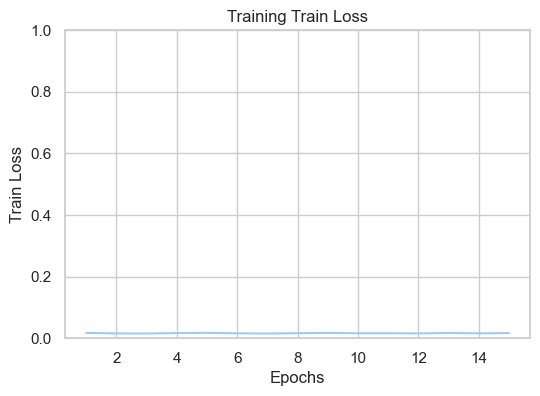

Standard Test


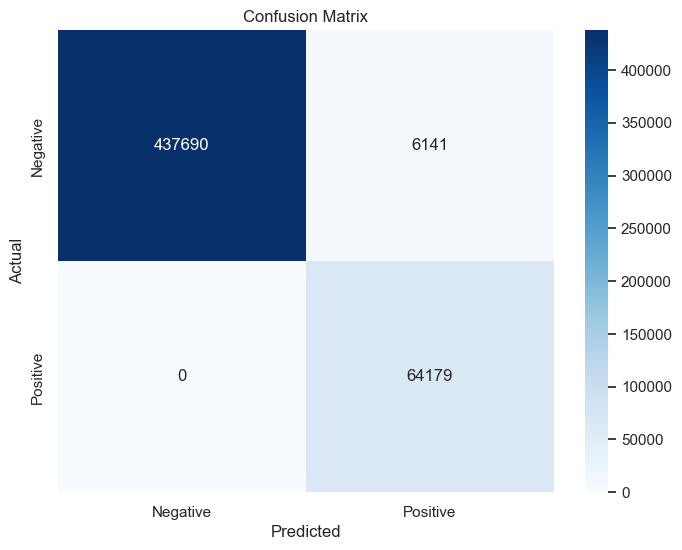

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/007-128'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.07
epochs = 15
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

c:\Users\adi_s\Desktop\mm\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [00:

Test Loss: 0.0294, Test Accuracy: 0.9879, Test F1: 0.9883


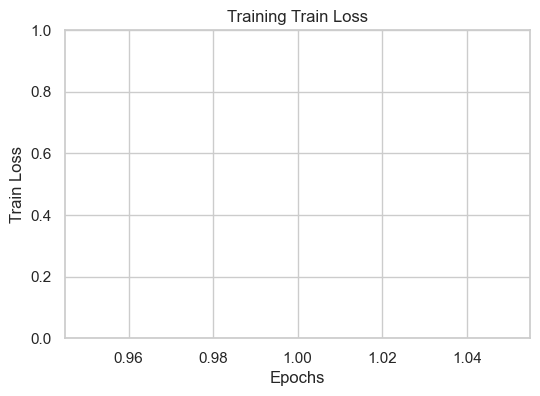

Standard Test


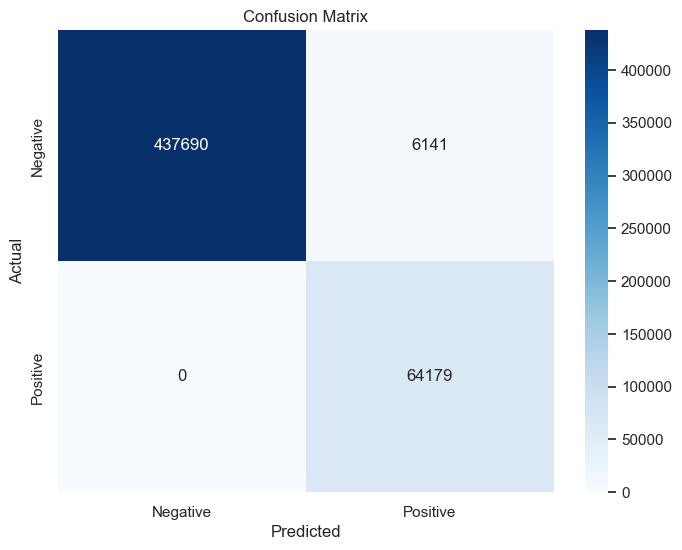

In [25]:
model1.load_model('./Models/saved_models/02/smote/007-128/PB_epoch_15.pth')
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [27]:
X_test['actual'] = y_test
X_test['preds'] = model1.test_predicted
X_test.to_csv('X_test_full.csv')
X_test2 = X_test[X_test['preds'] == 1]
X_test2.to_csv('X_test_SMOTE.csv')

In [ ]:
model1.test()